In [1]:
# basics
import os, sys

# arrays
import numpy as np
import pandas as pd
import xarray as xr

from datetime import (
    datetime,
    timedelta
)

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
sys.path.insert(0, '/home/metocean/geocean-nz-ss')
data_path = '/data' #'/data/storm_surge_data/'
os.environ["SSURGE_DATA_PATH"] = data_path

# custom
from sscode.config import data_path, default_region_reduced, default_evaluation_metrics, default_region
from sscode.utils import (
    calculate_relative_winds,
    spatial_gradient
)

# warnings
import warnings
warnings.filterwarnings('ignore')

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
%matplotlib inline

DATA PATH /data


In [2]:
# dataset attrs
datasets_attrs = {
    'era5': ('longitude','latitude',None,'ERA 5 reanalysis','u10','v10'),
    #'cfsr': ('lon','lat',None,'CFSR reanalysis','U_GRD_L103','V_GRD_L103'),
     'cfsr': ('longitude','latitude',None,'CFSR reanalysis','ugrd10m','vgrd10m'),
    'dac': ('longitude','latitude',None,'DAC global reanalysis'),
    'moana': ('lon','lat','site','Moana v2 hindcast'),
    'codec': ('codec_coords_lon','codec_coords_lat','name','CoDEC reanalysis'),
    'uhslc': ('longitude','latitude','name','UHSLC tgs'),
    'linz': ('longitude','latitude','name','LINZ tgs'),
    'other': ('longitude','latitude','name','OTHER tgs'),
    'privtgs': ('longitude','latitude','name','Private tgs')
}

In [3]:
ss_dset = xr.open_zarr(os.path.join(data_path, 'storm_surge_data/moana_hindcast_v2/moana_coast.zarr/'))
ss_dset = ss_dset.isel(site=np.logical_and(ss_dset.lat>-50, ss_dset.lon < 180))
predictand = ss_dset.ss\
                    .sel(time=slice(datetime(1994,12,1), datetime(2017,2,1,1)))\
                    .drop_duplicates('time')\
                    .chunk(dict(time=-1))\
                    .interpolate_na(dim='time')\
                    .transpose()\
                    .load()

In [4]:
def get_best_predictor_for_site(location,
                                dx=2.5,
                                region=None,
                                normalised=True):
    
    from sscode.utils import spatial_gradient
    
    pres_vars = ('SLP','longitude','latitude')
    wind_vars = ('wind_proj_mask','longitude','latitude','U_GRD_L103','V_GRD_L103')
    
    if region is None:
        region = (
                  location[0]-dx,
                  location[0]+dx,
                  location[1]-dx,
                  location[1]+dx
                )
    
    region_large = (
              region[0]-1,
              region[1]+1,
              region[2]-1,
              region[3]+1
            )

    print("Loading U")
    uw = xr.open_dataset(os.path.join(data_path, 'cfsr',
                                      'wnd10m/cfsr_wnd_1979_2021.nc'))[datasets_attrs['cfsr'][4]]\
                    .sel(time=slice(datetime(1994,11,1), datetime(2017,3,1)))\
                    .sel({
                      wind_vars[1]:slice(region_large[0],region_large[1]),
                      wind_vars[2]:slice(region_large[2],region_large[3])
                    })\
                    .sortby(datasets_attrs['cfsr'][0],ascending=True)\
                    .sortby(datasets_attrs['cfsr'][1],ascending=True)
    print("Done")

    print("Loading V")
    vw = xr.open_dataset(os.path.join(data_path, 'cfsr',
                                                  'wnd10m/cfsr_wnd_1979_2021.nc'))[datasets_attrs['cfsr'][5]]\
                    .sel(time=slice(datetime(1994,11,1), datetime(2017,3,1)))\
                    .sel({
                      wind_vars[1]:slice(region_large[0],region_large[1]),
                      wind_vars[2]:slice(region_large[2],region_large[3])
                    })\
                    .sortby(datasets_attrs['cfsr'][0],ascending=True)\
                    .sortby(datasets_attrs['cfsr'][1],ascending=True)
    print("Done")

    print("Calculating relative winds")
    wind = calculate_relative_winds(location=location, # load_winds[1],
                                    lat_name=datasets_attrs['cfsr'][1],
                                    lon_name=datasets_attrs['cfsr'][0],
                                    uw=uw,vw=vw)
    print("Done")

    print("Clearing U,V")
    del uw
    del vw
    print("Done")

    print("Loading MSLP")
    pres = xr.open_dataarray(os.path.join(data_path, 'cfsr',
                                          'CFSR_MSLP_1H_1990_2021.nc'))\
             .sel(time=slice(datetime(1994,11,1), datetime(2017,3,1)))\
             .sel({
                    pres_vars[1]:slice(region[0],region[1]),
                    pres_vars[2]:slice(region[2],region[3])
                    })\
             .sortby('longitude',ascending=True)\
             .sortby('latitude',ascending=True)
    print("Done")
    
    if pres_vars[0]=='wind_proj' or pres_vars[0]=='wind_proj_mask': # when just winds are loaded                                                                               
        pres = pres.fillna(0.0)
    else:
        pres = pres.dropna(dim='time',how='all')
    
    wind = wind[wind_vars[0]].fillna(0.0)\
                             .interp(coords={wind_vars[1]:pres[pres_vars[1]],
                                             wind_vars[2]:pres[pres_vars[2]]})\
                             .sel(time=pres.time) # interp to pressure coords                            
    
    # calculate the gradient                                                            
    print('\n calculating the gradient of the sea-level-pressure fields... \n')
    pres = spatial_gradient(pres,pres_vars[0]) # from utils.py                      
    print('\n pressure/gradient predictor both with shape: \n {} \n'\
            .format(pres[pres_vars[0]].shape))
        
    # Normalising
    if normalised:
        all_predictors =\
           xr.concat([
                      (pres.SLP.expand_dims("channel", -1)-pres.SLP.min())/(pres.SLP.max()-pres.SLP.min()),
                      (pres.SLP_gradient.expand_dims("channel", -1)-pres.SLP_gradient.min())/(pres.SLP_gradient.max()-pres.SLP.min()),
                      (wind.expand_dims("channel", -1)-wind.min())/(wind.max()-wind.min())
                     ],
                     "channel").fillna(0)
    else:
        all_predictors =\
           xr.concat([
                      pres.SLP.expand_dims("channel", -1),
                      pres.SLP_gradient.expand_dims("channel", -1),
                      wind.expand_dims("channel", -1)
                     ],
                     "channel").fillna(0)
    
    return all_predictors

In [5]:
import tensorflow.compat.v2 as tfv2
# pylint: disable=g-classes-have-attributes

# These functions are adapted from
# https://github.com/keras-team/keras/blob/06ba37b8662dea768b3bc8201942f1eb877708e8/keras/preprocessing/timeseries.py
# The main addition is that they targets have been modified to contain both the input grid and the ss output
# That way it is possible to use the dataset to train both heads of the network
    
def sequences_from_indices(array, indices_ds, start_index, end_index):
  dataset = tfv2.data.Dataset.from_tensors(array[start_index : end_index])
  dataset = tfv2.data.Dataset.zip((dataset.repeat(), indices_ds)).map(
      lambda steps, inds: tfv2.gather(steps, inds),  # pylint: disable=unnecessary-lambda
      num_parallel_calls=tfv2.data.AUTOTUNE)
  return dataset

def timeseries_dataset_from_array_seb(
    data,
    targets,
    targets_2,
    sequence_length,
    weights=None,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None):
  """Creates a dataset of sliding windows over a timeseries provided as array.
  This function takes in a sequence of data-points gathered at
  equal intervals, along with time series parameters such as
  length of the sequences/windows, spacing between two sequence/windows, etc.,
  to produce batches of timeseries inputs and targets.
  Args:
    data: Numpy array or eager tensor
      containing consecutive data points (timesteps).
      Axis 0 is expected to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
      `targets[i]` should be the target
      corresponding to the window that starts at index `i`
      (see example 2 below).
      Pass None if you don't have target data (in this case the dataset will
      only yield the input data).
    sequence_length: Length of the output sequences (in number of timesteps).
    sequence_stride: Period between successive output sequences.
      For stride `s`, output samples would
      start at index `data[i]`, `data[i + s]`, `data[i + 2 * s]`, etc.
    sampling_rate: Period between successive individual timesteps
      within sequences. For rate `r`, timesteps
      `data[i], data[i + r], ... data[i + sequence_length]`
      are used for create a sample sequence.
    batch_size: Number of timeseries samples in each batch
      (except maybe the last one).
    shuffle: Whether to shuffle output samples,
      or instead draw them in chronological order.
    seed: Optional int; random seed for shuffling.
    start_index: Optional int; data points earlier (exclusive)
      than `start_index` will not be used
      in the output sequences. This is useful to reserve part of the
      data for test or validation.
    end_index: Optional int; data points later (exclusive) than `end_index`
      will not be used in the output sequences.
      This is useful to reserve part of the data for test or validation.
  Returns:
    A tfv2.data.Dataset instance. If `targets` was passed, the dataset yields
    tuple `(batch_of_sequences, batch_of_targets)`. If not, the dataset yields
    only `batch_of_sequences`.
  Example 1:
  Consider indices `[0, 1, ... 99]`.
  With `sequence_length=10,  sampling_rate=2, sequence_stride=3`,
  `shuffle=False`, the dataset will yield batches of sequences
  composed of the following indices:
  ```
  First sequence:  [0  2  4  6  8 10 12 14 16 18]
  Second sequence: [3  5  7  9 11 13 15 17 19 21]
  Third sequence:  [6  8 10 12 14 16 18 20 22 24]
  ...
  Last sequence:   [78 80 82 84 86 88 90 92 94 96]
  ```
  In this case the last 3 data points are discarded since no full sequence
  can be generated to include them (the next sequence would have started
  at index 81, and thus its last step would have gone over 99).
  Example 2: Temporal regression.
  Consider an array `data` of scalar values, of shape `(steps,)`.
  To generate a dataset that uses the past 10
  timesteps to predict the next timestep, you would use:
  ```python
  input_data = data[:-10]
  targets = data[10:]
  dataset = tfv2.keras.preprocessing.timeseries_dataset_from_array(
      input_data, targets, sequence_length=10)
  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:10])  # First sequence: steps [0-9]
    assert np.array_equal(targets[0], data[10])  # Corresponding target: step 10
    break
  ```
  Example 3: Temporal regression for many-to-many architectures.
  Consider two arrays of scalar values `X` and `Y`,
  both of shape `(100,)`. The resulting dataset should consist samples with
  20 timestamps each. The samples should not overlap.
  To generate a dataset that uses the current timestamp
  to predict the corresponding target timestep, you would use:
  ```python
  X = np.arange(100)
  Y = X*2
  sample_length = 20
  input_dataset = tfv2.keras.preprocessing.timeseries_dataset_from_array(
    X, None, sequence_length=sample_length, sequence_stride=sample_length)
  target_dataset = tfv2.keras.preprocessing.timeseries_dataset_from_array(
    Y, None, sequence_length=sample_length, sequence_stride=sample_length)
  for batch in zip(input_dataset, target_dataset):
    inputs, targets = batch
    assert np.array_equal(inputs[0], X[:sample_length])
    # second sample equals output timestamps 20-40
    assert np.array_equal(targets[1], Y[sample_length:2*sample_length])
    break
  ```
  """
  if start_index:
    if start_index < 0:
      raise ValueError(f'`start_index` must be 0 or greater. Received: '
                       f'start_index={start_index}')
    if start_index >= len(data):
      raise ValueError(f'`start_index` must be lower than the length of the '
                       f'data. Received: start_index={start_index}, for data '
                       f'of length {len(data)}')
  if end_index:
    if start_index and end_index <= start_index:
      raise ValueError(f'`end_index` must be higher than `start_index`. '
                       f'Received: start_index={start_index}, and '
                       f'end_index={end_index} ')
    if end_index >= len(data):
      raise ValueError(f'`end_index` must be lower than the length of the '
                       f'data. Received: end_index={end_index}, for data of '
                       f'length {len(data)}')
    if end_index <= 0:
      raise ValueError('`end_index` must be higher than 0. '
                       f'Received: end_index={end_index}')

  # Validate strides
  if sampling_rate <= 0:
    raise ValueError(f'`sampling_rate` must be higher than 0. Received: '
                     f'sampling_rate={sampling_rate}')
  if sampling_rate >= len(data):
    raise ValueError(f'`sampling_rate` must be lower than the length of the '
                     f'data. Received: sampling_rate={sampling_rate}, for data '
                     f'of length {len(data)}')
  if sequence_stride <= 0:
    raise ValueError(f'`sequence_stride` must be higher than 0. Received: '
                     f'sequence_stride={sequence_stride}')
  if sequence_stride >= len(data):
    raise ValueError(f'`sequence_stride` must be lower than the length of the '
                     f'data. Received: sequence_stride={sequence_stride}, for '
                     f'data of length {len(data)}')

  if start_index is None:
    start_index = 0
  if end_index is None:
    end_index = len(data)

  # Determine the lowest dtype to store start positions (to lower memory usage).
  num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
  if targets is not None:
    num_seqs = min(num_seqs, len(targets))
  if num_seqs < 2147483647:
    index_dtype = 'int32'
  else:
    index_dtype = 'int64'

  # Generate start positions
  start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
  if shuffle:
    if seed is None:
      seed = np.random.randint(1e6)
    rng = np.random.RandomState(seed)
    rng.shuffle(start_positions)

  sequence_length = tfv2.cast(sequence_length, dtype=index_dtype)
  sampling_rate = tfv2.cast(sampling_rate, dtype=index_dtype)

  positions_ds = tfv2.data.Dataset.from_tensors(start_positions).repeat()

  # For each initial window position, generates indices of the window elements
  indices = tfv2.data.Dataset.zip(
      (tfv2.data.Dataset.range(len(start_positions)), positions_ds)).map(
          lambda i, positions: tfv2.range(  # pylint: disable=g-long-lambda
              positions[i],
              positions[i] + sequence_length * sampling_rate,
              sampling_rate),
          num_parallel_calls=tfv2.data.AUTOTUNE)

  dataset = sequences_from_indices(data, indices, start_index, end_index)
  outputs = [dataset]
  if targets is not None:
    indices = tfv2.data.Dataset.zip(
        (tfv2.data.Dataset.range(len(start_positions)), positions_ds)).map(
            lambda i, positions: positions[i],
            num_parallel_calls=tfv2.data.AUTOTUNE)
    print(targets.__class__)
    target_ds = sequences_from_indices(
        targets, indices, start_index, end_index)
    
    if targets_2 is not None:
        target_ds_2 = sequences_from_indices(
            targets_2, indices, start_index, end_index)
        outputs.append((target_ds, target_ds_2))
    else:
    #outputs.append((target_ds, dataset))
        outputs.append(target_ds)
    ##dataset = tfv2.data.Dataset.zip((dataset, (target_ds, dataset)))
    
    #outputs.append((target_ds, dataset))
    #outputs.append(target_ds)

  if weights is not None:
    indices = tfv2.data.Dataset.zip(
        (tfv2.data.Dataset.range(len(start_positions)), positions_ds)).map(
            lambda i, positions: positions[i],
            num_parallel_calls=tfv2.data.AUTOTUNE)
    print(weights.__class__)
    target_weights_dset = sequences_from_indices(
            weights, indices, start_index, end_index)
    
    indices = tfv2.data.Dataset.zip(
      (tfv2.data.Dataset.range(len(start_positions)), positions_ds)).map(
          lambda i, positions: tfv2.range(  # pylint: disable=g-long-lambda
              positions[i],
              positions[i] + sequence_length * sampling_rate,
              sampling_rate),
          num_parallel_calls=tfv2.data.AUTOTUNE)

    ae_weights_dset = sequences_from_indices(np.ones(data.shape[:-1]+(1,)), indices, start_index, end_index)
    outputs.append((target_weights_dset, ae_weights_dset))
    #dataset = tfv2.data.Dataset.zip((dataset, (target_ds, dataset)))
  dataset = tfv2.data.Dataset.zip(tuple(outputs))
  if shuffle:
    # Shuffle locally at each iteration
    dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
  dataset = dataset.prefetch(tfv2.data.AUTOTUNE).batch(batch_size)
  return dataset

In [177]:
from sscode.validation import generate_stats
from sscode.config import (
    default_evaluation_metrics,
    default_ext_quantile
)

def calculate_stats(ts1, ts2):
    title, stats = generate_stats(ts1,
                              ts2,
                              metrics=default_evaluation_metrics,
                              ext_quantile=default_ext_quantile)
    for metric in ['bias', 'si',
                   'rmse', 'kgeprime', 'rmse_95', 'rmse_99',
                   'pearson', 'pearson_95', 'pearson_99',
                   'rscore', 'rscore_95', 'rscore_99',
                   'nse', 'nse_95', 'nse_99',
                   'kge', 'ext_kge_95', 'ext_kge_99']:
        print(metric, stats[metric])
    return stats

In [8]:
from tensorflow.keras.layers import (
    Conv2D,
    Conv3D,
    BatchNormalization,
    MaxPool2D,
    MaxPool3D,
    ConvLSTM2D,
    GlobalMaxPool2D,
    Flatten, Dropout,
    TimeDistributed,
    GRU,
    Dense,
    Dropout,
    Conv1D,
    LSTM,
    Conv2DTranspose,
    Reshape,
    Cropping2D,
    Cropping1D,
    Activation,
    Lambda,
    Concatenate,
    TimeDistributed,
    Flatten,
    Reshape
)
import tensorflow as tf
from tensorflow.keras.models import Model

In [9]:
# This one works!!!
def build_model_cnn(shape_in,
                    nbout=1):

    inputs = tf.keras.Input(shape=shape_in)
    
    conv_1 = TimeDistributed(Conv2D(24, (3,3), padding='same', activation='relu'))(inputs)
    cnn_outputs = TimeDistributed(MaxPool2D((2,2)))(conv_1)     
    
    flat = Flatten()(cnn_outputs)

    dense_1 = Dense(48,
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001),
                    )(flat)
    
    dropout_1 = Dropout(0.1)(dense_1)
    
    out = Dense(nbout,
                activation='linear',
                use_bias=True)(dropout_1)

    model = Model(inputs=inputs, outputs=out)

    print(model.summary())
    
    return model

In [10]:
import tensorflow as tf

to_use=1

gpus = tf.config.list_physical_devices('GPU')

try:
    tf.config.set_visible_devices(gpus[to_use], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print("Failed to select GPU")

2 Physical GPUs, 1 Logical GPU


In [168]:
def get_training_and_validation_sets(predictors,
                                     predictand,
                                     input_sequence_length,
                                     input_sequence_frequency,
                                     lead_time,
                                     target_sequence_frequency,
                                     fold=0,
                                     n_folds=5,
                                     batch_size=32,
                                     print_test=False):
    
    if ( not (predictand.time.values[1:]-predictand.time.values[:-1]).max() ==\
        (predictand.time.values[1:]-predictand.time.values[:-1]).min() ):
        print("Time spacing is not constant in predictand dataset")
        raise
    
    if ( not (predictors.time.values[1:]-predictors.time.values[:-1]).max() ==\
        (predictors.time.values[1:]-predictors.time.values[:-1]).min() ):
            print("Time spacing is not constant in predictor dataset")
            raise
    
    # Find start, end and extent of dataset
    [tstart_predictor, tend_predictor] = predictors.time.values[[0,-1]].astype('datetime64[s]').tolist()
    [tstart_predictand, tend_predictand] = predictand.time.values[[0,-1]].astype('datetime64[s]').tolist()
    tstart = max(tstart_predictand, tstart_predictor)
    tend = min(tend_predictand, tend_predictor)
    time_extent = tend - tstart

    print("Returning fold ",fold," of ", n_folds, " e.g. %2.1f percent training data"%((n_folds-1)/n_folds*100.))

    # Finding time bounds of training data segments
    tstart_1 = tstart
    tend_1 = (tstart + time_extent*((n_folds-1-fold)/n_folds)).replace(second=0, microsecond=0, minute=0)

    tstart_2 = (tstart + time_extent*((n_folds-fold)/n_folds)).replace(second=0, microsecond=0, minute=0)
    tend_2 = tend
    print("")
    
    train_dset = []
    for tstart_train, tend_train in zip([tstart_1, tstart_2],[tend_1, tend_2]):
        if tstart_train != tend_train:
            print(tstart_train, tend_train)

            predictor_train =\
                predictors.sel(time=slice(tstart_train,
                                          tend_train-timedelta(hours=(lead_time-target_sequence_frequency))))\
                          .rolling(time=input_sequence_frequency).mean()\
                          .shift(time=-(input_sequence_frequency-1))\
                          .isel(time=slice(0,-(input_sequence_frequency-1)))\
                          .fillna(0)

            ss_train = predictand.sel(time=slice(tstart_train+timedelta(hours=input_sequence_length+lead_time-target_sequence_frequency),
                                      tend_train))\
                                 .chunk(dict(time=-1))\
                                 .interpolate_na(dim='time')\
                                 .rolling(time=target_sequence_frequency).max()\
                                 .shift(time=-(target_sequence_frequency-1))\
                                 .isel(time=slice(0,-(target_sequence_frequency-1)))\
                                 .expand_dims("channel", -1)*100

            if print_test: # To check indices are fine
                test_dset = timeseries_dataset_from_array_seb(
                    (predictor_train.time.values.astype(np.int)-786412800000000000)//3600000000000,
                    (ss_train.time.values.astype(np.int)-786412800000000000)//3600000000000,
                    targets_2=None,
                    weights=None,
                    sequence_length=int(input_sequence_length/input_sequence_frequency),
                    sequence_stride=int(target_sequence_frequency/input_sequence_frequency),
                    sampling_rate=input_sequence_frequency,
                    batch_size=4, shuffle=True, seed=None, start_index=None, end_index=None
                    )
        
                print("All integer correspond to number of hours with respect to reference date")
                for batch in test_dset:
                    inputs, targets = batch
                    for v1, v2 in zip(inputs, targets):
                        print("Times in:", v1, "Times out:", v2)
                    print_test = False
                    break
                print("")

            train_dset.append(timeseries_dataset_from_array_seb(
                    predictor_train,
                    ss_train,
                    targets_2=None,
                weights=None,
                sequence_length=int(input_sequence_length/input_sequence_frequency),
                sequence_stride=int(target_sequence_frequency/input_sequence_frequency),
                sampling_rate=input_sequence_frequency,
                batch_size=batch_size, shuffle=True, seed=None, start_index=None, end_index=None
                ))
            
    # If multiple segments concatenate them into a single dataset
    if len(train_dset) == 1:
        train_dset = train_dset[0]
    else:
        assert len(train_dset) == 2
        train_dset = train_dset[0].concatenate(train_dset[1])


    # Validation data
    predictor_val = predictors.sel(time=slice(tend_1,
                                              tstart_2-timedelta(hours=(lead_time-target_sequence_frequency))))\
                              .rolling(time=input_sequence_frequency).mean()\
                              .shift(time=-(input_sequence_frequency-1))\
                              .isel(time=slice(0,-(input_sequence_frequency-1)))\
                              .fillna(0)

    ss_val = predictand.sel(time=slice(tend_1+timedelta(hours=input_sequence_length+lead_time-target_sequence_frequency),
                                       tstart_2))\
                       .chunk(dict(time=-1))\
                       .interpolate_na(dim='time')\
                       .rolling(time=target_sequence_frequency).max()\
                       .shift(time=-(target_sequence_frequency-1))\
                       .isel(time=slice(0,-(target_sequence_frequency-1)))\
                       .expand_dims("channel", -1)*100


    val_dset = timeseries_dataset_from_array_seb(
        predictor_val,
        ss_val,
        targets_2=None,
        weights=None,
        sequence_length=int(input_sequence_length/input_sequence_frequency),
        sequence_stride=int(target_sequence_frequency/input_sequence_frequency),
        sampling_rate=input_sequence_frequency,
        batch_size=batch_size, shuffle=False, seed=None, start_index=None, end_index=None
    )

    return train_dset, val_dset

In [ ]:
new_results = {}
#for site_id in [ 224 ]:
for site_id in np.unique( # closest Moana v2 Hindcast to tidal gauges
                [ 689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
                  1296,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
                  1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
                ]
            ):
    
    
    location = (float(ss_dset.sel(site=site_id).lon.values),
                    float(ss_dset.sel(site=site_id).lat.values))
    
    
    all_predictors = get_best_predictor_for_site(location)
    
    new_results[site_id]={}
    
    
    
    for fold in range(5):
        
    #try:
    #if True:

        dset_train, dset_val = get_training_and_validation_sets(predictors=all_predictors,
                                                        predictand=predictand.sel(site=site_id),
                                                        input_sequence_length=input_sequence_length,
                                                        input_sequence_frequency=input_sequence_frequency,
                                                        lead_time=lead_time,
                                                        target_sequence_frequency=target_sequence_frequency,
                                                        batch_size=32,
                                                        n_folds=5,
                                                        fold=fold,
                                                        print_test=True
                                                               )


        shape_in=(int(input_sequence_length/input_sequence_frequency),) + dset_train.element_spec[0].shape[2:]
        model_cnn = build_model_cnn(shape_in=shape_in,
                                    nbout=dset_train.element_spec[1].shape[1])

        optimizer = tf.keras.optimizers.Adam(0.0001)
        model_cnn.compile(
                optimizer,
                loss='mse', 
                metrics=['mse', 'mae'],
        )

        history = model_cnn.fit(dset_train,
                                validation_data=dset_val,
                                epochs=20)

        prediction_val = model_cnn.predict(dset_val)

        new_results[site_id][fold] = calculate_stats(np.concatenate([y.numpy()[:,0] for x, y in dset_val], axis=0)/100, prediction_val[:,0]/100)
        new_results[site_id][fold]['history'] = history
        new_results[site_id][fold]['prediction'] = prediction_val
        

Loading U
Done
Loading V
Done
Calculating relative winds

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 23, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -50.11 -49.8 -49.49 ... -43.56 -43.24
  * longitude       (longitude) float32 165.0 165.3 165.6 ... 170.9 171.2 171.6
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugrd10m         (time, latitude, longitude) float32 -9.86 -9.789 ... -2.205
    vgrd10m         (time, latitude, longitude) float32 11.66 11.62 ... 2.572
    uw2             (time, latitude, longitude) float32 97.21 95.83 ... 4.861
    vw2             (time, latitude, longitude) float32 135.9 135.0 ... 6.617
    wind_magnitude  (time, latitude, longitude) float32 15.27 15.19 ... 3.388
Attributes:
    short_name:  ugrd10m
    long_name:   U-Component of Wind
    level:       10 m above ground
    units:       m/s 

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the w

Epoch 1/20
4855/4855 [==============================] - 8s 2ms/step - loss: 50.1068 - mse: 50.0477 - mae: 5.4760 - val_loss: 39.5802 - val_mse: 39.5098 - val_mae: 4.9657
Epoch 2/20
4855/4855 [==============================] - 8s 2ms/step - loss: 38.5805 - mse: 38.5020 - mae: 4.8617 - val_loss: 37.8939 - val_mse: 37.8067 - val_mae: 4.8536
Epoch 3/20
4855/4855 [==============================] - 8s 2ms/step - loss: 37.3281 - mse: 37.2339 - mae: 4.7736 - val_loss: 37.1518 - val_mse: 37.0503 - val_mae: 4.7951
Epoch 4/20
4855/4855 [==============================] - 8s 2ms/step - loss: 36.7407 - mse: 36.6331 - mae: 4.7331 - val_loss: 36.7433 - val_mse: 36.6296 - val_mae: 4.7623
Epoch 5/20
4855/4855 [==============================] - 8s 2ms/step - loss: 36.3999 - mse: 36.2810 - mae: 4.7119 - val_loss: 37.0393 - val_mse: 36.9157 - val_mae: 4.7732
Epoch 6/20
4855/4855 [==============================] - 8s 2ms/step - loss: 35.9153 - mse: 35.7862 - mae: 4.6805 - val_loss: 36.7856 - val_mse: 36.651

4856/4856 [==============================] - 13s 3ms/step - loss: 36.3476 - mse: 36.1953 - mae: 4.7247 - val_loss: 33.5487 - val_mse: 33.3931 - val_mae: 4.4427
Epoch 15/20
4856/4856 [==============================] - 12s 3ms/step - loss: 36.1282 - mse: 35.9700 - mae: 4.7075 - val_loss: 33.1661 - val_mse: 33.0048 - val_mae: 4.4168
Epoch 16/20
4856/4856 [==============================] - 12s 3ms/step - loss: 35.8398 - mse: 35.6764 - mae: 4.6847 - val_loss: 32.4633 - val_mse: 32.2975 - val_mae: 4.3711
Epoch 17/20
4856/4856 [==============================] - 12s 2ms/step - loss: 35.5148 - mse: 35.3475 - mae: 4.6681 - val_loss: 32.3761 - val_mse: 32.2069 - val_mae: 4.3644
Epoch 18/20
4856/4856 [==============================] - 12s 2ms/step - loss: 35.2685 - mse: 35.0976 - mae: 4.6510 - val_loss: 32.6636 - val_mse: 32.4911 - val_mae: 4.3821
Epoch 19/20
4856/4856 [==============================] - 13s 3ms/step - loss: 35.2208 - mse: 35.0471 - mae: 4.6396 - val_loss: 31.7964 - val_mse: 31.621

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_257"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_258 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_514 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_515 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_257 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_514 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_257 (Dropout)        (None, 20)                0         
_______________________________________

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 43.2141 - mse: 43.1664 - mae: 5.0643 - val_loss: 27.2060 - val_mse: 27.1493 - val_mae: 4.1810
Epoch 2/20
4857/4857 [==============================] - 8s 2ms/step - loss: 31.4710 - mse: 31.4118 - mae: 4.3799 - val_loss: 26.2510 - val_mse: 26.1898 - val_mae: 4.1133
Epoch 3/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.6537 - mse: 30.5904 - mae: 4.3199 - val_loss: 25.4965 - val_mse: 25.4310 - val_mae: 4.0545
Epoch 4/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.3571 - mse: 30.2898 - mae: 4.2964 - val_loss: 25.4019 - val_mse: 25.3333 - val_mae: 4.0459
Epoch 5/20
4857/4857 [==============================] - 8s 2ms/step - loss: 30.0425 - mse: 29.9727 - mae: 4.2739 - val_loss: 24.9439 - val_mse: 24.8732 - val_mae: 4.0026
Epoch 6/20
4857/4857 [==============================] - 8s 2ms/step - loss: 29.9871 - mse: 29.9155 - mae: 4.2660 - val_loss: 25.1202 - val_mse: 25.047

4855/4855 [==============================] - 12s 2ms/step - loss: 27.7460 - mse: 27.6180 - mae: 4.0895 - val_loss: 24.3435 - val_mse: 24.2146 - val_mae: 3.9311
Epoch 15/20
4855/4855 [==============================] - 12s 3ms/step - loss: 27.4490 - mse: 27.3183 - mae: 4.0726 - val_loss: 25.7517 - val_mse: 25.6201 - val_mae: 4.0393
Epoch 16/20
4855/4855 [==============================] - 12s 3ms/step - loss: 27.3123 - mse: 27.1788 - mae: 4.0585 - val_loss: 24.4187 - val_mse: 24.2845 - val_mae: 3.9347
Epoch 17/20
4855/4855 [==============================] - 12s 3ms/step - loss: 27.3599 - mse: 27.2241 - mae: 4.0575 - val_loss: 24.9033 - val_mse: 24.7669 - val_mae: 3.9728
Epoch 18/20
4855/4855 [==============================] - 12s 3ms/step - loss: 27.0867 - mse: 26.9489 - mae: 4.0386 - val_loss: 25.0913 - val_mse: 24.9530 - val_mae: 3.9868
Epoch 19/20
4855/4855 [==============================] - 12s 3ms/step - loss: 27.0350 - mse: 26.8953 - mae: 4.0381 - val_loss: 25.8671 - val_mse: 25.726

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_261"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_262 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_522 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_523 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_261 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_522 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_261 (Dropout)        (None, 20)                0         
_______________________________________

Epoch 7/20
4857/4857 [==============================] - 8s 2ms/step - loss: 29.6479 - mse: 29.5395 - mae: 4.2407 - val_loss: 23.9994 - val_mse: 23.8882 - val_mae: 3.8964
Epoch 8/20
4857/4857 [==============================] - 8s 2ms/step - loss: 29.5541 - mse: 29.4404 - mae: 4.2296 - val_loss: 23.7375 - val_mse: 23.6215 - val_mae: 3.8687
Epoch 9/20
4857/4857 [==============================] - 8s 2ms/step - loss: 29.3422 - mse: 29.2236 - mae: 4.2139 - val_loss: 23.5956 - val_mse: 23.4745 - val_mae: 3.8594
Epoch 10/20
4857/4857 [==============================] - 8s 2ms/step - loss: 29.1464 - mse: 29.0229 - mae: 4.1974 - val_loss: 23.2769 - val_mse: 23.1510 - val_mae: 3.8289
Epoch 11/20
4857/4857 [==============================] - 8s 2ms/step - loss: 29.0458 - mse: 28.9180 - mae: 4.1900 - val_loss: 23.0078 - val_mse: 22.8778 - val_mae: 3.8034
Epoch 12/20
4857/4857 [==============================] - 8s 2ms/step - loss: 28.8768 - mse: 28.7452 - mae: 4.1744 - val_loss: 22.9484 - val_mse: 22.

4857/4857 [==============================] - 7s 2ms/step - loss: 31.7006 - mse: 31.5518 - mae: 4.4025 - val_loss: 30.9225 - val_mse: 30.7714 - val_mae: 4.4228
Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.4975 - mse: 31.3445 - mae: 4.3862 - val_loss: 31.1101 - val_mse: 30.9548 - val_mae: 4.4374
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.3847 - mse: 31.2275 - mae: 4.3777 - val_loss: 31.1263 - val_mse: 30.9672 - val_mae: 4.4304
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.3022 - mse: 31.1413 - mae: 4.3686 - val_loss: 31.6503 - val_mse: 31.4875 - val_mae: 4.4723
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.2727 - mse: 31.1080 - mae: 4.3697 - val_loss: 30.9336 - val_mse: 30.7672 - val_mae: 4.4220
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 31.1332 - mse: 30.9652 - mae: 4.3599 - val_loss: 31.1871 - val_mse: 31.0173 - va

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_265"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_266 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_530 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_531 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_265 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_530 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_265 (Dropout)        (None, 20)                0         
_______________________________________

4855/4855 [==============================] - 7s 2ms/step - loss: 35.2013 - mse: 35.1156 - mae: 4.6509 - val_loss: 32.5800 - val_mse: 32.4934 - val_mae: 4.4890
Epoch 7/20
4855/4855 [==============================] - 8s 2ms/step - loss: 34.9656 - mse: 34.8784 - mae: 4.6366 - val_loss: 33.2770 - val_mse: 33.1887 - val_mae: 4.5437
Epoch 8/20
4855/4855 [==============================] - 7s 2ms/step - loss: 34.7363 - mse: 34.6475 - mae: 4.6206 - val_loss: 32.2512 - val_mse: 32.1613 - val_mae: 4.4656
Epoch 9/20
4855/4855 [==============================] - 7s 2ms/step - loss: 34.6038 - mse: 34.5129 - mae: 4.6100 - val_loss: 32.1372 - val_mse: 32.0450 - val_mae: 4.4588
Epoch 10/20
4855/4855 [==============================] - 7s 2ms/step - loss: 34.4944 - mse: 34.4013 - mae: 4.6018 - val_loss: 32.1335 - val_mse: 32.0393 - val_mae: 4.4555
Epoch 11/20
4855/4855 [==============================] - 7s 2ms/step - loss: 34.2337 - mse: 34.1382 - mae: 4.5857 - val_loss: 31.7793 - val_mse: 31.6826 - val_m

Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 32.4885 - mse: 32.3301 - mae: 4.4675 - val_loss: 27.1783 - val_mse: 27.0182 - val_mae: 4.1345
bias 0.0071206302
si 0.50869423
rmse 0.051979076
kgeprime [0.72904296]
rmse_95 0.08763353
rmse_99 0.1138489
pearson 0.8445952332644026
pearson_95 0.537086588309469
pearson_99 0.8065359350587725
rscore 0.7061907057235612
rscore_95 -2.852406855238749
rscore_99 -5.620990133345912
nse [0.70619071]
nse_95 [-2.85240686]
nse_99 [-5.62099013]
kge [0.66708037]
ext_kge_95 [0.43614371]
ext_kge_99 [0.5844192]
Loading U
Done
Loading V
Done
Calculating relative winds

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 23, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -47.61 -47.3 -46.99 ... -41.37 -41.06
  * longitude       (longitude) float32 167.8 168.1 168.4 ... 174.1 174.4 174.7
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    ugr

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_269"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_270 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_538 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_539 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_269 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_538 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_269 (Dropout)        (None, 20)                0         
_______________________________________

4856/4856 [==============================] - 7s 2ms/step - loss: 38.4627 - mse: 38.3512 - mae: 4.8900 - val_loss: 37.8869 - val_mse: 37.7701 - val_mae: 4.6437
Epoch 7/20
4856/4856 [==============================] - 7s 2ms/step - loss: 37.8925 - mse: 37.7728 - mae: 4.8535 - val_loss: 37.4398 - val_mse: 37.3155 - val_mae: 4.6173
Epoch 8/20
4856/4856 [==============================] - 7s 2ms/step - loss: 37.4747 - mse: 37.3475 - mae: 4.8246 - val_loss: 37.2030 - val_mse: 37.0716 - val_mae: 4.6033
Epoch 9/20
4856/4856 [==============================] - 7s 2ms/step - loss: 37.1026 - mse: 36.9687 - mae: 4.8008 - val_loss: 36.8361 - val_mse: 36.6982 - val_mae: 4.5811
Epoch 10/20
4856/4856 [==============================] - 7s 2ms/step - loss: 37.0752 - mse: 36.9352 - mae: 4.7984 - val_loss: 36.7609 - val_mse: 36.6171 - val_mae: 4.5751
Epoch 11/20
4856/4856 [==============================] - 7s 2ms/step - loss: 36.6940 - mse: 36.5482 - mae: 4.7752 - val_loss: 36.6310 - val_mse: 36.4821 - val_m

4855/4855 [==============================] - 7s 2ms/step - loss: 34.7986 - mse: 34.6027 - mae: 4.6146 - val_loss: 34.7430 - val_mse: 34.5452 - val_mae: 4.6358
Epoch 20/20
4855/4855 [==============================] - 7s 2ms/step - loss: 34.6119 - mse: 34.4125 - mae: 4.5994 - val_loss: 34.6115 - val_mse: 34.4103 - val_mae: 4.6260
bias 0.0018437766
si 0.5884927
rmse 0.058660235
kgeprime [0.77200718]
rmse_95 0.0773412
rmse_99 0.09220124
pearson 0.789291965225118
pearson_95 0.37957583693389163
pearson_99 0.5700278888618908
rscore 0.6142263939123523
rscore_95 -5.269613745203405
rscore_99 -23.160161594355507
nse [0.61422639]
nse_95 [-5.26961375]
nse_99 [-23.16016159]
kge [0.75103375]
ext_kge_95 [-0.06880165]
ext_kge_99 [-1.17335564]
Returning fold  4  of  5  e.g. 80.0 percent training data

1999-05-08 14:00:00 2017-02-01 01:00:00
<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([122403 122427 122451], shape=(3,), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
Model: "model_273"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_274 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_546 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_547 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_273 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_546 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_273 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_547 (Dens

4855/4855 [==============================] - 7s 2ms/step - loss: 22.1690 - mse: 22.0788 - mae: 3.6569 - val_loss: 19.5711 - val_mse: 19.4794 - val_mae: 3.5061
Epoch 7/20
4855/4855 [==============================] - 7s 2ms/step - loss: 22.0082 - mse: 21.9139 - mae: 3.6415 - val_loss: 19.2834 - val_mse: 19.1879 - val_mae: 3.4754
Epoch 8/20
4855/4855 [==============================] - 7s 2ms/step - loss: 21.8305 - mse: 21.7328 - mae: 3.6214 - val_loss: 19.4645 - val_mse: 19.3659 - val_mae: 3.4811
Epoch 9/20
4855/4855 [==============================] - 7s 2ms/step - loss: 21.6228 - mse: 21.5219 - mae: 3.6054 - val_loss: 18.8848 - val_mse: 18.7831 - val_mae: 3.4316
Epoch 10/20
4855/4855 [==============================] - 7s 2ms/step - loss: 21.4817 - mse: 21.3778 - mae: 3.5924 - val_loss: 18.9182 - val_mse: 18.8137 - val_mae: 3.4349
Epoch 11/20
4855/4855 [==============================] - 7s 2ms/step - loss: 21.3316 - mse: 21.2248 - mae: 3.5789 - val_loss: 18.6090 - val_mse: 18.5016 - val_m

4856/4856 [==============================] - 7s 2ms/step - loss: 20.2382 - mse: 20.1151 - mae: 3.5251 - val_loss: 19.6818 - val_mse: 19.5583 - val_mae: 3.3327
Epoch 20/20
4856/4856 [==============================] - 7s 2ms/step - loss: 20.2111 - mse: 20.0870 - mae: 3.5225 - val_loss: 19.8603 - val_mse: 19.7355 - val_mae: 3.3517
bias 0.0048688496
si 0.47695276
rmse 0.0444247
kgeprime [0.78016746]
rmse_95 0.09394951
rmse_99 0.16249572
pearson 0.8683857145661098
pearson_95 0.09921733635530838
pearson_99 -0.7670998288051133
rscore 0.7440894076625257
rscore_95 -2.9638015437145597
rscore_99 -10.309404968433002
nse [0.74408941]
nse_95 [-2.96380154]
nse_99 [-10.30940497]
kge [0.69822179]
ext_kge_95 [0.05228937]
ext_kge_99 [-0.86428467]
Returning fold  3  of  5  e.g. 80.0 percent training data

1994-12-01 00:00:00 1999-05-08 14:00:00
<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([30090 30114 30138], shape=(3,), dtype=int64) 

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 31.5014 - mse: 31.4457 - mae: 4.3068 - val_loss: 20.4478 - val_mse: 20.3802 - val_mae: 3.5978
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 23.9437 - mse: 23.8697 - mae: 3.7998 - val_loss: 19.6741 - val_mse: 19.5951 - val_mae: 3.5272
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 23.3528 - mse: 23.2705 - mae: 3.7514 - val_loss: 19.1193 - val_mse: 19.0346 - val_mae: 3.4703
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 23.0640 - mse: 22.9773 - mae: 3.7298 - val_loss: 19.1121 - val_mse: 19.0234 - val_mae: 3.4701
Epoch 5/20
4857/4857 [==============================] - 8s 2ms/step - loss: 22.9578 - mse: 22.8676 - mae: 3.7192 - val_loss: 18.9197 - val_mse: 18.8279 - val_mae: 3.4509
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 22.7435 - mse: 22.6500 - mae: 3.7024 - val_loss: 18.9305 - val_mse: 18.835

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.8989 - mse: 36.7570 - mae: 4.7433 - val_loss: 35.6837 - val_mse: 35.5391 - val_mae: 4.6988
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.8680 - mse: 36.7212 - mae: 4.7365 - val_loss: 35.7834 - val_mse: 35.6340 - val_mae: 4.7028
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.5317 - mse: 36.3803 - mae: 4.7155 - val_loss: 35.8018 - val_mse: 35.6482 - val_mae: 4.7083
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.4334 - mse: 36.2779 - mae: 4.7083 - val_loss: 35.3440 - val_mse: 35.1862 - val_mae: 4.6821
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.3059 - mse: 36.1461 - mae: 4.6994 - val_loss: 35.6710 - val_mse: 35.5091 - val_mae: 4.7010
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.1426 - mse: 35.9792 - mae: 4.6887 - val_loss: 35.4050 - val_mse: 35

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([44742 44766 44790], shape=(3,), dtype=int64) Times out: tf.Tensor(44790, shape=(), dtype=int64)
Times in: tf.Tensor([70680 70704 70728], shape=(3,), dtype=int64) Times out: tf.Tensor(70728, shape=(), dtype=int64)
Times in: tf.Tensor([66426 66450 66474], shape=(3,), dtype=int64) Times out: tf.Tensor(66474, shape=(), dtype=int64)
Times in: tf.Tensor([67900 67924 67948], shape=(3,), dtype=int64) Times out: tf.Tensor(67948, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
2008-03-20 19:00:00 2017-02-01 01:00:00
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_280"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_281 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
___________________________________________________

4855/4855 [==============================] - 7s 2ms/step - loss: 41.7670 - mse: 41.6940 - mae: 5.0453 - val_loss: 36.6252 - val_mse: 36.5441 - val_mae: 4.7493
Epoch 3/20
4855/4855 [==============================] - 7s 2ms/step - loss: 39.9936 - mse: 39.9070 - mae: 4.9350 - val_loss: 36.1372 - val_mse: 36.0451 - val_mae: 4.7009
Epoch 4/20
4855/4855 [==============================] - 7s 2ms/step - loss: 39.2525 - mse: 39.1571 - mae: 4.8904 - val_loss: 35.3440 - val_mse: 35.2450 - val_mae: 4.6508
Epoch 5/20
4855/4855 [==============================] - 7s 2ms/step - loss: 38.8383 - mse: 38.7364 - mae: 4.8636 - val_loss: 35.1301 - val_mse: 35.0253 - val_mae: 4.6321
Epoch 6/20
4855/4855 [==============================] - 7s 2ms/step - loss: 38.4460 - mse: 38.3387 - mae: 4.8407 - val_loss: 34.9987 - val_mse: 34.8889 - val_mae: 4.6227
Epoch 7/20
4855/4855 [==============================] - 7s 2ms/step - loss: 38.2512 - mse: 38.1391 - mae: 4.8248 - val_loss: 34.7150 - val_mse: 34.6006 - val_mae

Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.1695 - mse: 35.9956 - mae: 4.6926 - val_loss: 31.8429 - val_mse: 31.6679 - val_mae: 4.4798
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 36.0092 - mse: 35.8327 - mae: 4.6762 - val_loss: 31.0154 - val_mse: 30.8376 - val_mae: 4.4035
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.7446 - mse: 35.5653 - mae: 4.6613 - val_loss: 30.7549 - val_mse: 30.5742 - val_mae: 4.3808
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.6462 - mse: 35.4640 - mae: 4.6548 - val_loss: 30.4474 - val_mse: 30.2641 - val_mae: 4.3550
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 35.6021 - mse: 35.4170 - mae: 4.6489 - val_loss: 30.3770 - val_mse: 30.1906 - val_mae: 4.3469
bias 0.0010519649
si 0.5690264
rmse 0.054945994
kgeprime [0.72036326]
rmse_95 0.08769006
rmse_99 0.11176121
pearson 0.7986358749761335
pearson_95

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([71740 71764 71788], shape=(3,), dtype=int64) Times out: tf.Tensor(71788, shape=(), dtype=int64)
Times in: tf.Tensor([1432 1456 1480], shape=(3,), dtype=int64) Times out: tf.Tensor(1480, shape=(), dtype=int64)
Times in: tf.Tensor([99066 99090 99114], shape=(3,), dtype=int64) Times out: tf.Tensor(99114, shape=(), dtype=int64)
Times in: tf.Tensor([30433 30457 30481], shape=(3,), dtype=int64) Times out: tf.Tensor(30481, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
2012-08-26 10:00:00 2017-02-01 01:00:00
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_284"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_285 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_______________________________________________________

4856/4856 [==============================] - 7s 2ms/step - loss: 40.4065 - mse: 40.3268 - mae: 5.0150 - val_loss: 39.2002 - val_mse: 39.1112 - val_mae: 4.7347
Epoch 3/20
4856/4856 [==============================] - 7s 2ms/step - loss: 38.7603 - mse: 38.6667 - mae: 4.9084 - val_loss: 38.4423 - val_mse: 38.3422 - val_mae: 4.6906
Epoch 4/20
4856/4856 [==============================] - 7s 2ms/step - loss: 38.1877 - mse: 38.0840 - mae: 4.8724 - val_loss: 38.2533 - val_mse: 38.1445 - val_mae: 4.6795
Epoch 5/20
4856/4856 [==============================] - 7s 2ms/step - loss: 37.8970 - mse: 37.7852 - mae: 4.8496 - val_loss: 37.8598 - val_mse: 37.7437 - val_mae: 4.6513
Epoch 6/20
4856/4856 [==============================] - 7s 2ms/step - loss: 37.5052 - mse: 37.3868 - mae: 4.8262 - val_loss: 37.7415 - val_mse: 37.6197 - val_mae: 4.6345
Epoch 7/20
4856/4856 [==============================] - 7s 2ms/step - loss: 37.3695 - mse: 37.2455 - mae: 4.8165 - val_loss: 37.5094 - val_mse: 37.3823 - val_mae

4855/4855 [==============================] - 7s 2ms/step - loss: 36.3568 - mse: 36.2282 - mae: 4.7030 - val_loss: 34.3139 - val_mse: 34.1838 - val_mae: 4.5658
Epoch 16/20
4855/4855 [==============================] - 7s 2ms/step - loss: 36.1396 - mse: 36.0072 - mae: 4.6906 - val_loss: 35.1088 - val_mse: 34.9746 - val_mae: 4.6139
Epoch 17/20
4855/4855 [==============================] - 7s 2ms/step - loss: 35.9257 - mse: 35.7894 - mae: 4.6783 - val_loss: 34.3057 - val_mse: 34.1678 - val_mae: 4.5668
Epoch 18/20
4855/4855 [==============================] - 7s 2ms/step - loss: 35.8099 - mse: 35.6698 - mae: 4.6669 - val_loss: 34.4921 - val_mse: 34.3505 - val_mae: 4.5698
Epoch 19/20
4855/4855 [==============================] - 8s 2ms/step - loss: 35.7228 - mse: 35.5788 - mae: 4.6617 - val_loss: 34.0818 - val_mse: 33.9362 - val_mae: 4.5484
Epoch 20/20
4855/4855 [==============================] - 7s 2ms/step - loss: 35.6558 - mse: 35.5082 - mae: 4.6576 - val_loss: 34.0169 - val_mse: 33.8679 - va

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (195745, 10, 10) 

Returning fold  0  of  5  e.g. 80.0 percent training data

1994-12-01 00:00:00 2012-08-26 10:00:00
<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([48156 48180 48204], shape=(3,), dtype=int64) Times out: tf.Tensor(48204, shape=(), dtype=int64)
Times in: tf.Tensor([47102 47126 47150], shape=(3,), dtype=int64) Times out: tf.Tensor(47150, shape=(), dtype=int64)
Times in: tf.Tensor([93907 93931 93955], shape=(3,), dtype=int64) Times out: tf.Tensor(93955, shape=(), dtype=int64)
Times in: tf.Tensor([43968 43992 44016], shape=(3,), dtype=int64) Times out: tf.Tensor(44016, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_288"
__________________

4855/4855 [==============================] - 8s 2ms/step - loss: 27.2345 - mse: 27.1921 - mae: 4.0949 - val_loss: 25.1409 - val_mse: 25.0873 - val_mae: 3.9357
Epoch 2/20
4855/4855 [==============================] - 7s 2ms/step - loss: 22.9297 - mse: 22.8708 - mae: 3.7787 - val_loss: 24.5501 - val_mse: 24.4852 - val_mae: 3.8826
Epoch 3/20
4855/4855 [==============================] - 7s 2ms/step - loss: 22.5723 - mse: 22.5040 - mae: 3.7454 - val_loss: 23.0754 - val_mse: 23.0035 - val_mae: 3.7481
Epoch 4/20
4855/4855 [==============================] - 7s 2ms/step - loss: 22.3467 - mse: 22.2730 - mae: 3.7234 - val_loss: 23.8212 - val_mse: 23.7448 - val_mae: 3.8187
Epoch 5/20
4855/4855 [==============================] - 7s 2ms/step - loss: 22.2188 - mse: 22.1413 - mae: 3.7133 - val_loss: 23.3968 - val_mse: 23.3172 - val_mae: 3.7808
Epoch 6/20
4855/4855 [==============================] - 7s 2ms/step - loss: 22.1271 - mse: 22.0463 - mae: 3.7065 - val_loss: 23.3878 - val_mse: 23.3048 - val_mae

4856/4856 [==============================] - 7s 2ms/step - loss: 21.0598 - mse: 20.9400 - mae: 3.6163 - val_loss: 20.0822 - val_mse: 19.9604 - val_mae: 3.4903
Epoch 15/20
4856/4856 [==============================] - 7s 2ms/step - loss: 21.0051 - mse: 20.8825 - mae: 3.6154 - val_loss: 20.0710 - val_mse: 19.9468 - val_mae: 3.4881
Epoch 16/20
4856/4856 [==============================] - 7s 2ms/step - loss: 20.9348 - mse: 20.8097 - mae: 3.6111 - val_loss: 20.0577 - val_mse: 19.9309 - val_mae: 3.4859
Epoch 17/20
4856/4856 [==============================] - 8s 2ms/step - loss: 20.8570 - mse: 20.7295 - mae: 3.6004 - val_loss: 19.9935 - val_mse: 19.8645 - val_mae: 3.4802
Epoch 18/20
4856/4856 [==============================] - 7s 2ms/step - loss: 20.7919 - mse: 20.6620 - mae: 3.5947 - val_loss: 19.9442 - val_mse: 19.8127 - val_mae: 3.4752
Epoch 19/20
4856/4856 [==============================] - 7s 2ms/step - loss: 20.7427 - mse: 20.6100 - mae: 3.5902 - val_loss: 20.1468 - val_mse: 20.0126 - va

<class 'xarray.core.dataarray.DataArray'>
Model: "model_292"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_293 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_584 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_585 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_292 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_584 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_292 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_585 (Dens

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 29.0715 - mse: 29.0255 - mae: 4.1400 - val_loss: 20.4079 - val_mse: 20.3544 - val_mae: 3.4942
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 23.4400 - mse: 23.3822 - mae: 3.7508 - val_loss: 19.6536 - val_mse: 19.5921 - val_mae: 3.4341
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 22.7469 - mse: 22.6822 - mae: 3.6922 - val_loss: 19.2239 - val_mse: 19.1562 - val_mae: 3.4258
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 22.2225 - mse: 22.1525 - mae: 3.6504 - val_loss: 18.7821 - val_mse: 18.7096 - val_mae: 3.3740
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 21.9780 - mse: 21.9031 - mae: 3.6282 - val_loss: 18.5164 - val_mse: 18.4390 - val_mae: 3.3580
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 21.5525 - mse: 21.4728 - mae: 3.5916 - val_loss: 18.2665 - val_mse: 18.184

4855/4855 [==============================] - 7s 2ms/step - loss: 18.1373 - mse: 17.9916 - mae: 3.3079 - val_loss: 17.8413 - val_mse: 17.6940 - val_mae: 3.2540
Epoch 15/20
4855/4855 [==============================] - 7s 2ms/step - loss: 18.0469 - mse: 17.8979 - mae: 3.3004 - val_loss: 17.8593 - val_mse: 17.7089 - val_mae: 3.2534
Epoch 16/20
4855/4855 [==============================] - 7s 2ms/step - loss: 17.9735 - mse: 17.8216 - mae: 3.2933 - val_loss: 17.8166 - val_mse: 17.6632 - val_mae: 3.2519
Epoch 17/20
4855/4855 [==============================] - 7s 2ms/step - loss: 17.8484 - mse: 17.6938 - mae: 3.2815 - val_loss: 17.7287 - val_mse: 17.5727 - val_mae: 3.2444
Epoch 18/20
4855/4855 [==============================] - 7s 2ms/step - loss: 17.7550 - mse: 17.5981 - mae: 3.2738 - val_loss: 17.6411 - val_mse: 17.4830 - val_mae: 3.2368
Epoch 19/20
4855/4855 [==============================] - 7s 2ms/step - loss: 17.6459 - mse: 17.4867 - mae: 3.2620 - val_loss: 17.6792 - val_mse: 17.5189 - va

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_296"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_297 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_592 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_593 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_296 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_592 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_296 (Dropout)        (None, 20)                0         
_______________________________________

Epoch 7/20
4857/4857 [==============================] - 7s 2ms/step - loss: 23.2862 - mse: 23.2034 - mae: 3.7254 - val_loss: 19.9729 - val_mse: 19.8883 - val_mae: 3.4706
Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 23.1886 - mse: 23.1025 - mae: 3.7189 - val_loss: 19.9349 - val_mse: 19.8475 - val_mae: 3.4646
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 23.0458 - mse: 22.9567 - mae: 3.7011 - val_loss: 19.4857 - val_mse: 19.3953 - val_mae: 3.4260
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 22.8219 - mse: 22.7301 - mae: 3.6911 - val_loss: 19.1229 - val_mse: 19.0296 - val_mae: 3.3976
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 22.7607 - mse: 22.6663 - mae: 3.6862 - val_loss: 19.6875 - val_mse: 19.5920 - val_mae: 3.4417
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 22.6963 - mse: 22.5997 - mae: 3.6775 - val_loss: 18.9730 - val_mse: 18.

Epoch 14/20
4857/4857 [==============================] - 7s 2ms/step - loss: 23.0878 - mse: 22.9503 - mae: 3.7699 - val_loss: 21.0559 - val_mse: 20.9177 - val_mae: 3.6088
Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 22.9788 - mse: 22.8396 - mae: 3.7589 - val_loss: 21.3860 - val_mse: 21.2460 - val_mae: 3.6386
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 22.9130 - mse: 22.7718 - mae: 3.7530 - val_loss: 21.4203 - val_mse: 21.2783 - val_mae: 3.6432
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 22.8938 - mse: 22.7508 - mae: 3.7516 - val_loss: 20.8440 - val_mse: 20.7004 - val_mae: 3.5919
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 22.7910 - mse: 22.6464 - mae: 3.7450 - val_loss: 21.1527 - val_mse: 21.0074 - val_mae: 3.6186
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 22.7544 - mse: 22.6082 - mae: 3.7397 - val_loss: 21.5832 - val_mse: 

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_300"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_301 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_600 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_601 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_300 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_600 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_300 (Dropout)        (None, 20)                0         
_______________________________________

4855/4855 [==============================] - 7s 2ms/step - loss: 26.4655 - mse: 26.3853 - mae: 4.0279 - val_loss: 24.9641 - val_mse: 24.8825 - val_mae: 3.9391
Epoch 7/20
4855/4855 [==============================] - 7s 2ms/step - loss: 26.2922 - mse: 26.2096 - mae: 4.0135 - val_loss: 24.8235 - val_mse: 24.7394 - val_mae: 3.9286
Epoch 8/20
4855/4855 [==============================] - 7s 2ms/step - loss: 26.1433 - mse: 26.0581 - mae: 4.0001 - val_loss: 24.6559 - val_mse: 24.5693 - val_mae: 3.9126
Epoch 9/20
4855/4855 [==============================] - 7s 2ms/step - loss: 26.0605 - mse: 25.9728 - mae: 3.9918 - val_loss: 24.5560 - val_mse: 24.4668 - val_mae: 3.9012
Epoch 10/20
4855/4855 [==============================] - 7s 2ms/step - loss: 25.8002 - mse: 25.7103 - mae: 3.9755 - val_loss: 24.4014 - val_mse: 24.3101 - val_mae: 3.8932
Epoch 11/20
4855/4855 [==============================] - 7s 2ms/step - loss: 25.6372 - mse: 25.5449 - mae: 3.9654 - val_loss: 24.4687 - val_mse: 24.3748 - val_m

Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.1190 - mse: 24.0081 - mae: 3.8246 - val_loss: 20.4854 - val_mse: 20.3734 - val_mae: 3.6263
bias 0.0017646408
si 0.5005164
rmse 0.04513685
kgeprime [0.77645898]
rmse_95 0.066529706
rmse_99 0.080622524
pearson 0.8448408361312462
pearson_95 0.6083295664543934
pearson_99 0.42945134620345493
rscore 0.7115192093570184
rscore_95 -2.4250886906929083
rscore_99 -5.1615972379905175
nse [0.71151921]
nse_95 [-2.42508869]
nse_99 [-5.16159724]
kge [0.74301922]
ext_kge_95 [0.49807398]
ext_kge_99 [0.35024043]
Loading U
Done
Loading V
Done
Calculating relative winds

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -44.49 -44.18 -43.87 ... -38.25 -37.94
  * longitude       (longitude) float32 170.0 170.3 170.6 ... 175.9 176.2 176.6
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:


<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_304"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_305 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_608 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_609 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_304 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_608 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_304 (Dropout)        (None, 20)                0         
_______________________________________

4856/4856 [==============================] - 8s 2ms/step - loss: 19.9911 - mse: 19.9116 - mae: 3.5116 - val_loss: 18.2290 - val_mse: 18.1463 - val_mae: 3.2935
Epoch 7/20
4856/4856 [==============================] - 7s 2ms/step - loss: 19.8800 - mse: 19.7968 - mae: 3.5000 - val_loss: 18.0844 - val_mse: 17.9983 - val_mae: 3.2787
Epoch 8/20
4856/4856 [==============================] - 7s 2ms/step - loss: 19.7612 - mse: 19.6746 - mae: 3.4883 - val_loss: 18.1756 - val_mse: 18.0865 - val_mae: 3.2903
Epoch 9/20
4856/4856 [==============================] - 7s 2ms/step - loss: 19.6410 - mse: 19.5514 - mae: 3.4783 - val_loss: 18.0042 - val_mse: 17.9123 - val_mae: 3.2739
Epoch 10/20
4856/4856 [==============================] - 8s 2ms/step - loss: 19.5053 - mse: 19.4130 - mae: 3.4677 - val_loss: 17.9944 - val_mse: 17.9002 - val_mae: 3.2724
Epoch 11/20
4856/4856 [==============================] - 8s 2ms/step - loss: 19.4174 - mse: 19.3229 - mae: 3.4607 - val_loss: 17.9712 - val_mse: 17.8750 - val_m

4855/4855 [==============================] - 7s 2ms/step - loss: 18.6944 - mse: 18.5892 - mae: 3.3747 - val_loss: 21.1229 - val_mse: 21.0168 - val_mae: 3.6408
Epoch 20/20
4855/4855 [==============================] - 7s 2ms/step - loss: 18.6094 - mse: 18.5024 - mae: 3.3700 - val_loss: 21.4490 - val_mse: 21.3409 - val_mae: 3.6663
bias 0.002993172
si 0.6473929
rmse 0.046196245
kgeprime [0.70376115]
rmse_95 0.075287
rmse_99 0.09689305
pearson 0.7399017214866971
pearson_95 0.349218921927945
pearson_99 0.27542746096924103
rscore 0.536409241906618
rscore_95 -7.183276060406248
rscore_99 -22.066366441472063
nse [0.53640924]
nse_95 [-7.18327606]
nse_99 [-22.06636644]
kge [0.66241968]
ext_kge_95 [0.04410231]
ext_kge_99 [-0.61194463]
Returning fold  4  of  5  e.g. 80.0 percent training data

1999-05-08 14:00:00 2017-02-01 01:00:00
<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([158031 158055 158079], shape=(3,), dtype=int64) Tim

<class 'xarray.core.dataarray.DataArray'>
Model: "model_308"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_309 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_616 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_617 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_308 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_616 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_308 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_617 (Dens

4855/4855 [==============================] - 7s 2ms/step - loss: 19.5023 - mse: 19.4265 - mae: 3.4639 - val_loss: 20.4912 - val_mse: 20.4125 - val_mae: 3.5336
Epoch 7/20
4855/4855 [==============================] - 7s 2ms/step - loss: 19.3206 - mse: 19.2420 - mae: 3.4480 - val_loss: 20.3354 - val_mse: 20.2540 - val_mae: 3.5183
Epoch 8/20
4855/4855 [==============================] - 8s 2ms/step - loss: 19.2811 - mse: 19.1999 - mae: 3.4432 - val_loss: 20.1209 - val_mse: 20.0367 - val_mae: 3.5008
Epoch 9/20
4855/4855 [==============================] - 7s 2ms/step - loss: 19.1391 - mse: 19.0552 - mae: 3.4297 - val_loss: 20.1137 - val_mse: 20.0271 - val_mae: 3.4927
Epoch 10/20
4855/4855 [==============================] - 7s 2ms/step - loss: 19.1041 - mse: 19.0176 - mae: 3.4264 - val_loss: 20.0170 - val_mse: 19.9277 - val_mae: 3.4890
Epoch 11/20
4855/4855 [==============================] - 7s 2ms/step - loss: 19.0149 - mse: 18.9261 - mae: 3.4189 - val_loss: 19.9934 - val_mse: 19.9018 - val_m

4856/4856 [==============================] - 8s 2ms/step - loss: 18.1386 - mse: 18.0023 - mae: 3.3411 - val_loss: 17.1965 - val_mse: 17.0584 - val_mae: 3.1973
Epoch 20/20
4856/4856 [==============================] - 7s 2ms/step - loss: 18.0742 - mse: 17.9353 - mae: 3.3352 - val_loss: 17.3649 - val_mse: 17.2238 - val_mae: 3.2163
bias -0.0039604055
si 0.5719065
rmse 0.041501608
kgeprime [0.55918102]
rmse_95 0.06844434
rmse_99 0.07326542
pearson 0.8006499070395978
pearson_95 0.502901869336762
pearson_99 0.47421962130481343
rscore 0.6367538857172517
rscore_95 -4.575030700242177
rscore_99 -13.729861375819159
nse [0.63675389]
nse_95 [-4.5750307]
nse_99 [-13.72986138]
kge [0.64523881]
ext_kge_95 [0.20334363]
ext_kge_99 [-0.24310414]
Returning fold  3  of  5  e.g. 80.0 percent training data

1994-12-01 00:00:00 1999-05-08 14:00:00
<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([12479 12503 12527], shape=(3,), dtype=int64) Ti

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 27.5404 - mse: 27.4901 - mae: 4.0878 - val_loss: 18.4067 - val_mse: 18.3428 - val_mae: 3.3660
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 21.7283 - mse: 21.6597 - mae: 3.6449 - val_loss: 17.5632 - val_mse: 17.4904 - val_mae: 3.2995
Epoch 3/20
4857/4857 [==============================] - 8s 2ms/step - loss: 20.9567 - mse: 20.8802 - mae: 3.5814 - val_loss: 17.4823 - val_mse: 17.4029 - val_mae: 3.2970
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 20.6366 - mse: 20.5550 - mae: 3.5548 - val_loss: 17.3200 - val_mse: 17.2370 - val_mae: 3.2847
Epoch 5/20
4857/4857 [==============================] - 8s 2ms/step - loss: 20.4281 - mse: 20.3435 - mae: 3.5348 - val_loss: 16.9580 - val_mse: 16.8722 - val_mae: 3.2489
Epoch 6/20
4857/4857 [==============================] - 8s 2ms/step - loss: 20.2665 - mse: 20.1797 - mae: 3.5211 - val_loss: 17.0087 - val_mse: 16.921

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 20.4152 - mse: 20.3338 - mae: 3.5397 - val_loss: 17.9492 - val_mse: 17.8665 - val_mae: 3.3361
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 20.2929 - mse: 20.2093 - mae: 3.5300 - val_loss: 17.4273 - val_mse: 17.3425 - val_mae: 3.2800
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 20.1621 - mse: 20.0764 - mae: 3.5177 - val_loss: 17.4844 - val_mse: 17.3977 - val_mae: 3.2917
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 20.0518 - mse: 19.9643 - mae: 3.5092 - val_loss: 17.3554 - val_mse: 17.2668 - val_mae: 3.2737
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 19.9994 - mse: 19.9102 - mae: 3.5032 - val_loss: 17.4009 - val_mse: 17.3109 - val_mae: 3.2806
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 19.9363 - mse: 19.8455 - mae: 3.4948 - val_loss: 17.2979 - val_mse: 17

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([51194 51218 51242], shape=(3,), dtype=int64) Times out: tf.Tensor(51242, shape=(), dtype=int64)
Times in: tf.Tensor([42451 42475 42499], shape=(3,), dtype=int64) Times out: tf.Tensor(42499, shape=(), dtype=int64)
Times in: tf.Tensor([20325 20349 20373], shape=(3,), dtype=int64) Times out: tf.Tensor(20373, shape=(), dtype=int64)
Times in: tf.Tensor([60328 60352 60376], shape=(3,), dtype=int64) Times out: tf.Tensor(60376, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
2008-03-20 19:00:00 2017-02-01 01:00:00
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_315"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_316 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
___________________________________________________

4855/4855 [==============================] - 7s 2ms/step - loss: 21.4147 - mse: 21.3593 - mae: 3.6250 - val_loss: 22.1691 - val_mse: 22.1103 - val_mae: 3.7224
Epoch 3/20
4855/4855 [==============================] - 7s 2ms/step - loss: 20.8633 - mse: 20.8018 - mae: 3.5814 - val_loss: 22.2490 - val_mse: 22.1848 - val_mae: 3.7343
Epoch 4/20
4855/4855 [==============================] - 7s 2ms/step - loss: 20.5915 - mse: 20.5251 - mae: 3.5562 - val_loss: 21.8982 - val_mse: 21.8294 - val_mae: 3.6993
Epoch 5/20
4855/4855 [==============================] - 7s 2ms/step - loss: 20.2746 - mse: 20.2038 - mae: 3.5298 - val_loss: 21.4857 - val_mse: 21.4126 - val_mae: 3.6589
Epoch 6/20
4855/4855 [==============================] - 7s 2ms/step - loss: 20.0108 - mse: 19.9358 - mae: 3.5046 - val_loss: 21.0495 - val_mse: 20.9725 - val_mae: 3.6166
Epoch 7/20
4855/4855 [==============================] - 7s 2ms/step - loss: 19.8347 - mse: 19.7559 - mae: 3.4896 - val_loss: 21.3306 - val_mse: 21.2499 - val_mae

Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 20.1865 - mse: 20.0863 - mae: 3.4986 - val_loss: 17.5543 - val_mse: 17.4533 - val_mae: 3.3925
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 20.0545 - mse: 19.9528 - mae: 3.4926 - val_loss: 16.9431 - val_mse: 16.8407 - val_mae: 3.3242
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 20.0825 - mse: 19.9794 - mae: 3.4945 - val_loss: 17.2402 - val_mse: 17.1362 - val_mae: 3.3526
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 19.9744 - mse: 19.8701 - mae: 3.4812 - val_loss: 17.3223 - val_mse: 17.2174 - val_mae: 3.3644
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 19.9491 - mse: 19.8434 - mae: 3.4821 - val_loss: 16.8913 - val_mse: 16.7853 - val_mae: 3.3178
bias 0.0035849388
si 0.50675744
rmse 0.040969875
kgeprime [0.78365573]
rmse_95 0.059003063
rmse_99 0.072660446
pearson 0.8426908671645472
pearson

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([107927 107951 107975], shape=(3,), dtype=int64) Times out: tf.Tensor(107975, shape=(), dtype=int64)
Times in: tf.Tensor([83451 83475 83499], shape=(3,), dtype=int64) Times out: tf.Tensor(83499, shape=(), dtype=int64)
Times in: tf.Tensor([83770 83794 83818], shape=(3,), dtype=int64) Times out: tf.Tensor(83818, shape=(), dtype=int64)
Times in: tf.Tensor([15573 15597 15621], shape=(3,), dtype=int64) Times out: tf.Tensor(15621, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
2012-08-26 10:00:00 2017-02-01 01:00:00
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_319"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_320 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_______________________________________________

4856/4856 [==============================] - 7s 2ms/step - loss: 21.3041 - mse: 21.2306 - mae: 3.6114 - val_loss: 18.3494 - val_mse: 18.2672 - val_mae: 3.3195
Epoch 3/20
4856/4856 [==============================] - 8s 2ms/step - loss: 20.6168 - mse: 20.5323 - mae: 3.5492 - val_loss: 18.1712 - val_mse: 18.0793 - val_mae: 3.3164
Epoch 4/20
4856/4856 [==============================] - 8s 2ms/step - loss: 20.2845 - mse: 20.1910 - mae: 3.5226 - val_loss: 17.9968 - val_mse: 17.8969 - val_mae: 3.3062
Epoch 5/20
4856/4856 [==============================] - 7s 2ms/step - loss: 20.0693 - mse: 19.9687 - mae: 3.5064 - val_loss: 17.9153 - val_mse: 17.8097 - val_mae: 3.3026
Epoch 6/20
4856/4856 [==============================] - 8s 2ms/step - loss: 19.8141 - mse: 19.7081 - mae: 3.4831 - val_loss: 17.8951 - val_mse: 17.7852 - val_mae: 3.3039
Epoch 7/20
4856/4856 [==============================] - 8s 2ms/step - loss: 19.5755 - mse: 19.4656 - mae: 3.4622 - val_loss: 17.5857 - val_mse: 17.4723 - val_mae

4855/4855 [==============================] - 7s 2ms/step - loss: 18.4185 - mse: 18.3116 - mae: 3.3427 - val_loss: 20.1691 - val_mse: 20.0609 - val_mae: 3.5647
Epoch 16/20
4855/4855 [==============================] - 7s 2ms/step - loss: 18.3608 - mse: 18.2519 - mae: 3.3347 - val_loss: 20.0804 - val_mse: 19.9704 - val_mae: 3.5603
Epoch 17/20
4855/4855 [==============================] - 7s 2ms/step - loss: 18.3305 - mse: 18.2196 - mae: 3.3324 - val_loss: 20.1033 - val_mse: 19.9913 - val_mae: 3.5671
Epoch 18/20
4855/4855 [==============================] - 7s 2ms/step - loss: 18.2310 - mse: 18.1181 - mae: 3.3215 - val_loss: 20.0610 - val_mse: 19.9470 - val_mae: 3.5561
Epoch 19/20
4855/4855 [==============================] - 7s 2ms/step - loss: 18.1488 - mse: 18.0339 - mae: 3.3156 - val_loss: 19.9711 - val_mse: 19.8552 - val_mae: 3.5515
Epoch 20/20
4855/4855 [==============================] - 7s 2ms/step - loss: 18.1348 - mse: 18.0179 - mae: 3.3150 - val_loss: 19.9767 - val_mse: 19.8587 - va

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (195745, 10, 10) 

Returning fold  0  of  5  e.g. 80.0 percent training data

1994-12-01 00:00:00 2012-08-26 10:00:00
<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([140216 140240 140264], shape=(3,), dtype=int64) Times out: tf.Tensor(140264, shape=(), dtype=int64)
Times in: tf.Tensor([48976 49000 49024], shape=(3,), dtype=int64) Times out: tf.Tensor(49024, shape=(), dtype=int64)
Times in: tf.Tensor([98445 98469 98493], shape=(3,), dtype=int64) Times out: tf.Tensor(98493, shape=(), dtype=int64)
Times in: tf.Tensor([59373 59397 59421], shape=(3,), dtype=int64) Times out: tf.Tensor(59421, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_323"
______________

4855/4855 [==============================] - 8s 2ms/step - loss: 25.5932 - mse: 25.5536 - mae: 3.9394 - val_loss: 20.5528 - val_mse: 20.5082 - val_mae: 3.5410
Epoch 2/20
4855/4855 [==============================] - 7s 2ms/step - loss: 20.7947 - mse: 20.7497 - mae: 3.5775 - val_loss: 20.1179 - val_mse: 20.0718 - val_mae: 3.4973
Epoch 3/20
4855/4855 [==============================] - 7s 2ms/step - loss: 20.3600 - mse: 20.3130 - mae: 3.5376 - val_loss: 19.8278 - val_mse: 19.7790 - val_mae: 3.4734
Epoch 4/20
4855/4855 [==============================] - 7s 2ms/step - loss: 20.0929 - mse: 20.0433 - mae: 3.5119 - val_loss: 19.7020 - val_mse: 19.6510 - val_mae: 3.4625
Epoch 5/20
4855/4855 [==============================] - 7s 2ms/step - loss: 20.1361 - mse: 20.0848 - mae: 3.5132 - val_loss: 19.8921 - val_mse: 19.8395 - val_mae: 3.4798
Epoch 6/20
4855/4855 [==============================] - 7s 2ms/step - loss: 20.0150 - mse: 19.9621 - mae: 3.5038 - val_loss: 19.4595 - val_mse: 19.4053 - val_mae

4856/4856 [==============================] - 7s 2ms/step - loss: 17.7745 - mse: 17.6596 - mae: 3.3203 - val_loss: 17.3084 - val_mse: 17.1925 - val_mae: 3.1866
Epoch 15/20
4856/4856 [==============================] - 7s 2ms/step - loss: 17.6689 - mse: 17.5522 - mae: 3.3120 - val_loss: 17.2132 - val_mse: 17.0954 - val_mae: 3.1784
Epoch 16/20
4856/4856 [==============================] - 7s 2ms/step - loss: 17.7061 - mse: 17.5871 - mae: 3.3124 - val_loss: 17.2406 - val_mse: 17.1205 - val_mae: 3.1841
Epoch 17/20
4856/4856 [==============================] - 7s 2ms/step - loss: 17.6352 - mse: 17.5142 - mae: 3.3062 - val_loss: 17.3056 - val_mse: 17.1835 - val_mae: 3.1901
Epoch 18/20
4856/4856 [==============================] - 7s 2ms/step - loss: 17.5463 - mse: 17.4230 - mae: 3.2964 - val_loss: 17.1931 - val_mse: 17.0686 - val_mae: 3.1747
Epoch 19/20
4856/4856 [==============================] - 7s 2ms/step - loss: 17.5605 - mse: 17.4348 - mae: 3.3007 - val_loss: 17.1798 - val_mse: 17.0530 - va

<class 'xarray.core.dataarray.DataArray'>
Model: "model_327"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_328 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_654 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_655 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_327 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_654 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_327 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_655 (Dens

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 37.2698 - mse: 37.2281 - mae: 4.6479 - val_loss: 23.5417 - val_mse: 23.4904 - val_mae: 3.7353
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 27.3906 - mse: 27.3351 - mae: 4.0267 - val_loss: 22.5854 - val_mse: 22.5262 - val_mae: 3.6773
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.4906 - mse: 26.4283 - mae: 3.9567 - val_loss: 22.0925 - val_mse: 22.0272 - val_mae: 3.6343
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 26.0310 - mse: 25.9635 - mae: 3.9243 - val_loss: 21.7711 - val_mse: 21.7014 - val_mae: 3.6085
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.7618 - mse: 25.6901 - mae: 3.9075 - val_loss: 21.7960 - val_mse: 21.7223 - val_mae: 3.6217
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.5826 - mse: 25.5072 - mae: 3.8938 - val_loss: 21.5248 - val_mse: 21.447

4855/4855 [==============================] - 7s 2ms/step - loss: 22.2037 - mse: 22.0775 - mae: 3.6270 - val_loss: 22.0883 - val_mse: 21.9599 - val_mae: 3.6390
Epoch 15/20
4855/4855 [==============================] - 7s 2ms/step - loss: 22.0620 - mse: 21.9326 - mae: 3.6138 - val_loss: 21.9532 - val_mse: 21.8216 - val_mae: 3.6332
Epoch 16/20
4855/4855 [==============================] - 7s 2ms/step - loss: 21.9238 - mse: 21.7912 - mae: 3.6081 - val_loss: 21.7422 - val_mse: 21.6075 - val_mae: 3.6165
Epoch 17/20
4855/4855 [==============================] - 7s 2ms/step - loss: 21.8265 - mse: 21.6908 - mae: 3.5977 - val_loss: 21.7848 - val_mse: 21.6468 - val_mae: 3.6180
Epoch 18/20
4855/4855 [==============================] - 7s 2ms/step - loss: 21.7765 - mse: 21.6379 - mae: 3.5921 - val_loss: 21.7849 - val_mse: 21.6441 - val_mae: 3.6156
Epoch 19/20
4855/4855 [==============================] - 7s 2ms/step - loss: 21.6860 - mse: 21.5445 - mae: 3.5835 - val_loss: 21.6581 - val_mse: 21.5145 - va

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_331"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_332 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_662 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_663 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_331 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_662 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_331 (Dropout)        (None, 20)                0         
_______________________________________

Epoch 7/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.5956 - mse: 25.5282 - mae: 3.8873 - val_loss: 20.5970 - val_mse: 20.5280 - val_mae: 3.5755
Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.4236 - mse: 25.3526 - mae: 3.8759 - val_loss: 20.3991 - val_mse: 20.3260 - val_mae: 3.5558
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 25.2020 - mse: 25.1269 - mae: 3.8572 - val_loss: 20.2276 - val_mse: 20.1503 - val_mae: 3.5385
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.8795 - mse: 24.8001 - mae: 3.8340 - val_loss: 20.5782 - val_mse: 20.4964 - val_mae: 3.5915
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.8470 - mse: 24.7632 - mae: 3.8298 - val_loss: 19.7266 - val_mse: 19.6406 - val_mae: 3.5058
Epoch 12/20
4857/4857 [==============================] - 7s 2ms/step - loss: 24.4576 - mse: 24.3695 - mae: 3.7997 - val_loss: 19.6538 - val_mse: 19.

Epoch 14/20
4857/4857 [==============================] - 7s 2ms/step - loss: 20.5697 - mse: 20.4691 - mae: 3.5593 - val_loss: 17.3636 - val_mse: 17.2615 - val_mae: 3.3008
Epoch 15/20
4857/4857 [==============================] - 7s 2ms/step - loss: 20.4737 - mse: 20.3703 - mae: 3.5521 - val_loss: 17.3805 - val_mse: 17.2758 - val_mae: 3.3064
Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 20.4139 - mse: 20.3078 - mae: 3.5470 - val_loss: 17.3195 - val_mse: 17.2121 - val_mae: 3.2923
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 20.3529 - mse: 20.2443 - mae: 3.5390 - val_loss: 17.3002 - val_mse: 17.1903 - val_mae: 3.2928
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 20.3926 - mse: 20.2818 - mae: 3.5408 - val_loss: 17.4536 - val_mse: 17.3415 - val_mae: 3.3002
Epoch 19/20
4857/4857 [==============================] - 8s 2ms/step - loss: 20.2474 - mse: 20.1342 - mae: 3.5295 - val_loss: 17.3875 - val_mse: 

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_335"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_336 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_670 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_671 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_335 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_670 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_335 (Dropout)        (None, 20)                0         
_______________________________________

4855/4855 [==============================] - 7s 2ms/step - loss: 20.2431 - mse: 20.1388 - mae: 3.5160 - val_loss: 20.1084 - val_mse: 20.0012 - val_mae: 3.6005
Epoch 7/20
4855/4855 [==============================] - 8s 2ms/step - loss: 20.1557 - mse: 20.0470 - mae: 3.5085 - val_loss: 20.0341 - val_mse: 19.9235 - val_mae: 3.5936
Epoch 8/20
4855/4855 [==============================] - 7s 2ms/step - loss: 20.0214 - mse: 19.9091 - mae: 3.4937 - val_loss: 19.7328 - val_mse: 19.6191 - val_mae: 3.5653
Epoch 9/20
4855/4855 [==============================] - 7s 2ms/step - loss: 19.8838 - mse: 19.7684 - mae: 3.4852 - val_loss: 19.8974 - val_mse: 19.7806 - val_mae: 3.5819
Epoch 10/20
4855/4855 [==============================] - 7s 2ms/step - loss: 19.7864 - mse: 19.6681 - mae: 3.4744 - val_loss: 20.0150 - val_mse: 19.8954 - val_mae: 3.5940
Epoch 11/20
4855/4855 [==============================] - 7s 2ms/step - loss: 19.7354 - mse: 19.6146 - mae: 3.4701 - val_loss: 19.9185 - val_mse: 19.7969 - val_m

Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 19.9476 - mse: 19.8309 - mae: 3.5061 - val_loss: 17.8286 - val_mse: 17.7115 - val_mae: 3.3570
bias 0.0068888194
si 0.5489242
rmse 0.042085037
kgeprime [0.63777692]
rmse_95 0.0663169
rmse_99 0.08381747
pearson 0.8147284585229495
pearson_95 0.5644249040332745
pearson_99 0.49626809273344225
rscore 0.6545105300471239
rscore_95 -3.216668426097942
rscore_99 -9.569928024302413
nse [0.65451053]
nse_95 [-3.21666843]
nse_99 [-9.56992802]
kge [0.61271751]
ext_kge_95 [0.41111621]
ext_kge_99 [0.22891037]
Loading U
Done
Loading V
Done
Calculating relative winds

 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (latitude: 22, longitude: 22, time: 195745)
Coordinates:
  * latitude        (latitude) float32 -41.37 -41.06 -40.75 ... -35.13 -34.81
  * longitude       (longitude) float32 171.6 171.9 172.2 ... 177.5 177.8 178.1
  * time            (time) datetime64[ns] 1994-11-01 ... 2017-03-01
Data variables:
    

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_339"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_340 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_678 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_679 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_339 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_678 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_339 (Dropout)        (None, 20)                0         
_______________________________________

4856/4856 [==============================] - 7s 2ms/step - loss: 22.4552 - mse: 22.3754 - mae: 3.6772 - val_loss: 21.1524 - val_mse: 21.0692 - val_mae: 3.4396
Epoch 7/20
4856/4856 [==============================] - 7s 2ms/step - loss: 22.2979 - mse: 22.2141 - mae: 3.6644 - val_loss: 20.9471 - val_mse: 20.8600 - val_mae: 3.4242
Epoch 8/20
4856/4856 [==============================] - 7s 2ms/step - loss: 21.9540 - mse: 21.8656 - mae: 3.6359 - val_loss: 20.6598 - val_mse: 20.5677 - val_mae: 3.4021
Epoch 9/20
4856/4856 [==============================] - 7s 2ms/step - loss: 21.6498 - mse: 21.5567 - mae: 3.6152 - val_loss: 20.4918 - val_mse: 20.3948 - val_mae: 3.3910
Epoch 10/20
4856/4856 [==============================] - 7s 2ms/step - loss: 21.5597 - mse: 21.4615 - mae: 3.6037 - val_loss: 20.4410 - val_mse: 20.3389 - val_mae: 3.3920
Epoch 11/20
4856/4856 [==============================] - 7s 2ms/step - loss: 21.1817 - mse: 21.0786 - mae: 3.5697 - val_loss: 20.2741 - val_mse: 20.1679 - val_m

4855/4855 [==============================] - 8s 2ms/step - loss: 20.7048 - mse: 20.5570 - mae: 3.5007 - val_loss: 18.9165 - val_mse: 18.7672 - val_mae: 3.4018
Epoch 20/20
4855/4855 [==============================] - 8s 2ms/step - loss: 20.6142 - mse: 20.4640 - mae: 3.4914 - val_loss: 18.6357 - val_mse: 18.4842 - val_mae: 3.3693
bias 8.0049555e-05
si 0.49596778
rmse 0.04299327
kgeprime [0.81381054]
rmse_95 0.06294636
rmse_99 0.07554923
pearson 0.8531862216894962
pearson_95 0.547637830365553
pearson_99 0.4763236933211074
rscore 0.7270412256116352
rscore_95 -2.5929144456350293
rscore_99 -6.676718686686516
nse [0.72704123]
nse_95 [-2.59291445]
nse_99 [-6.67671869]
kge [0.81220001]
ext_kge_95 [0.30185622]
ext_kge_99 [0.01705334]
Returning fold  4  of  5  e.g. 80.0 percent training data

1999-05-08 14:00:00 2017-02-01 01:00:00
<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([179960 179984 180008], shape=(3,), dtype=int64) T

<class 'xarray.core.dataarray.DataArray'>
Model: "model_343"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_344 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_________________________________________________________________
time_distributed_686 (TimeDi (None, 3, 10, 10, 24)     672       
_________________________________________________________________
time_distributed_687 (TimeDi (None, 3, 5, 5, 24)       0         
_________________________________________________________________
flatten_343 (Flatten)        (None, 1800)              0         
_________________________________________________________________
dense_686 (Dense)            (None, 20)                36020     
_________________________________________________________________
dropout_343 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_687 (Dens

4855/4855 [==============================] - 7s 2ms/step - loss: 13.8454 - mse: 13.7450 - mae: 2.9094 - val_loss: 14.2585 - val_mse: 14.1560 - val_mae: 2.9193
Epoch 7/20
4855/4855 [==============================] - 7s 2ms/step - loss: 13.7214 - mse: 13.6148 - mae: 2.8936 - val_loss: 14.3672 - val_mse: 14.2590 - val_mae: 2.9298
Epoch 8/20
4855/4855 [==============================] - 7s 2ms/step - loss: 13.6376 - mse: 13.5255 - mae: 2.8808 - val_loss: 14.2545 - val_mse: 14.1413 - val_mae: 2.9167
Epoch 9/20
4855/4855 [==============================] - 7s 2ms/step - loss: 13.5090 - mse: 13.3920 - mae: 2.8683 - val_loss: 14.2887 - val_mse: 14.1709 - val_mae: 2.9222
Epoch 10/20
4855/4855 [==============================] - 7s 2ms/step - loss: 13.4580 - mse: 13.3368 - mae: 2.8620 - val_loss: 14.4163 - val_mse: 14.2946 - val_mae: 2.9325
Epoch 11/20
4855/4855 [==============================] - 7s 2ms/step - loss: 13.4181 - mse: 13.2932 - mae: 2.8583 - val_loss: 14.3611 - val_mse: 14.2360 - val_m

4856/4856 [==============================] - 7s 2ms/step - loss: 12.6425 - mse: 12.5019 - mae: 2.7715 - val_loss: 13.0796 - val_mse: 12.9385 - val_mae: 2.7730
Epoch 20/20
4856/4856 [==============================] - 7s 2ms/step - loss: 12.5299 - mse: 12.3866 - mae: 2.7610 - val_loss: 13.1242 - val_mse: 12.9803 - val_mae: 2.7715
bias 0.004228681
si 0.53467506
rmse 0.03602823
kgeprime [0.7303583]
rmse_95 0.07355796
rmse_99 0.10830082
pearson 0.8295850698970726
pearson_95 0.1991918969145397
pearson_99 -0.43961601674783907
rscore 0.6770480863897442
rscore_95 -5.265110258061786
rscore_99 -50.20633281754098
nse [0.67704809]
nse_95 [-5.26511026]
nse_99 [-50.20633282]
kge [0.63708329]
ext_kge_95 [0.03217183]
ext_kge_99 [-2.38621326]
Returning fold  3  of  5  e.g. 80.0 percent training data

1994-12-01 00:00:00 1999-05-08 14:00:00
<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([2398 2422 2446], shape=(3,), dtype=int64) Times 

Epoch 1/20
4857/4857 [==============================] - 8s 2ms/step - loss: 20.0440 - mse: 19.9966 - mae: 3.4475 - val_loss: 14.4202 - val_mse: 14.3582 - val_mae: 2.9481
Epoch 2/20
4857/4857 [==============================] - 7s 2ms/step - loss: 15.6791 - mse: 15.6121 - mae: 3.0823 - val_loss: 13.8973 - val_mse: 13.8251 - val_mae: 2.8975
Epoch 3/20
4857/4857 [==============================] - 7s 2ms/step - loss: 15.2825 - mse: 15.2061 - mae: 3.0472 - val_loss: 13.6379 - val_mse: 13.5570 - val_mae: 2.8707
Epoch 4/20
4857/4857 [==============================] - 7s 2ms/step - loss: 15.0880 - mse: 15.0038 - mae: 3.0277 - val_loss: 13.3057 - val_mse: 13.2173 - val_mae: 2.8321
Epoch 5/20
4857/4857 [==============================] - 7s 2ms/step - loss: 14.8401 - mse: 14.7486 - mae: 3.0016 - val_loss: 13.0860 - val_mse: 12.9907 - val_mae: 2.8134
Epoch 6/20
4857/4857 [==============================] - 7s 2ms/step - loss: 14.6522 - mse: 14.5543 - mae: 2.9838 - val_loss: 12.8325 - val_mse: 12.731

Epoch 8/20
4857/4857 [==============================] - 7s 2ms/step - loss: 14.7315 - mse: 14.6373 - mae: 3.0033 - val_loss: 11.8778 - val_mse: 11.7824 - val_mae: 2.7209
Epoch 9/20
4857/4857 [==============================] - 7s 2ms/step - loss: 14.6690 - mse: 14.5727 - mae: 2.9991 - val_loss: 11.9250 - val_mse: 11.8275 - val_mae: 2.7291
Epoch 10/20
4857/4857 [==============================] - 7s 2ms/step - loss: 14.5703 - mse: 14.4720 - mae: 2.9890 - val_loss: 11.6127 - val_mse: 11.5136 - val_mae: 2.6902
Epoch 11/20
4857/4857 [==============================] - 7s 2ms/step - loss: 14.4604 - mse: 14.3605 - mae: 2.9790 - val_loss: 11.5555 - val_mse: 11.4549 - val_mae: 2.6832
Epoch 12/20
4857/4857 [==============================] - 8s 2ms/step - loss: 14.4249 - mse: 14.3235 - mae: 2.9697 - val_loss: 11.5712 - val_mse: 11.4691 - val_mae: 2.6864
Epoch 13/20
4857/4857 [==============================] - 7s 2ms/step - loss: 14.3401 - mse: 14.2375 - mae: 2.9628 - val_loss: 11.5183 - val_mse: 11

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([1026 1050 1074], shape=(3,), dtype=int64) Times out: tf.Tensor(1074, shape=(), dtype=int64)
Times in: tf.Tensor([24457 24481 24505], shape=(3,), dtype=int64) Times out: tf.Tensor(24505, shape=(), dtype=int64)
Times in: tf.Tensor([1063 1087 1111], shape=(3,), dtype=int64) Times out: tf.Tensor(1111, shape=(), dtype=int64)
Times in: tf.Tensor([26138 26162 26186], shape=(3,), dtype=int64) Times out: tf.Tensor(26186, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
2008-03-20 19:00:00 2017-02-01 01:00:00
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_350"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_351 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
___________________________________________________________

4855/4855 [==============================] - 7s 2ms/step - loss: 15.3027 - mse: 15.2387 - mae: 3.0455 - val_loss: 15.3066 - val_mse: 15.2392 - val_mae: 3.1149
Epoch 3/20
4855/4855 [==============================] - 7s 2ms/step - loss: 14.8109 - mse: 14.7399 - mae: 2.9982 - val_loss: 14.9503 - val_mse: 14.8761 - val_mae: 3.0836
Epoch 4/20
4855/4855 [==============================] - 7s 2ms/step - loss: 14.5695 - mse: 14.4920 - mae: 2.9734 - val_loss: 14.6391 - val_mse: 14.5592 - val_mae: 3.0528
Epoch 5/20
4855/4855 [==============================] - 7s 2ms/step - loss: 14.3681 - mse: 14.2851 - mae: 2.9532 - val_loss: 14.5211 - val_mse: 14.4362 - val_mae: 3.0409
Epoch 6/20
4855/4855 [==============================] - 7s 2ms/step - loss: 14.2525 - mse: 14.1651 - mae: 2.9409 - val_loss: 14.2999 - val_mse: 14.2109 - val_mae: 3.0182
Epoch 7/20
4855/4855 [==============================] - 7s 2ms/step - loss: 14.1500 - mse: 14.0588 - mae: 2.9338 - val_loss: 14.2571 - val_mse: 14.1647 - val_mae

Epoch 16/20
4857/4857 [==============================] - 7s 2ms/step - loss: 13.6046 - mse: 13.4815 - mae: 2.8911 - val_loss: 12.7868 - val_mse: 12.6627 - val_mae: 2.8077
Epoch 17/20
4857/4857 [==============================] - 7s 2ms/step - loss: 13.5480 - mse: 13.4229 - mae: 2.8851 - val_loss: 12.5051 - val_mse: 12.3790 - val_mae: 2.7743
Epoch 18/20
4857/4857 [==============================] - 7s 2ms/step - loss: 13.4852 - mse: 13.3579 - mae: 2.8796 - val_loss: 12.5209 - val_mse: 12.3926 - val_mae: 2.7723
Epoch 19/20
4857/4857 [==============================] - 7s 2ms/step - loss: 13.4720 - mse: 13.3428 - mae: 2.8763 - val_loss: 12.5183 - val_mse: 12.3885 - val_mae: 2.7770
Epoch 20/20
4857/4857 [==============================] - 7s 2ms/step - loss: 13.4377 - mse: 13.3068 - mae: 2.8734 - val_loss: 12.4447 - val_mse: 12.3130 - val_mae: 2.7644
bias 0.00027080026
si 0.5476852
rmse 0.035089906
kgeprime [0.74078965]
rmse_95 0.053723402
rmse_99 0.07323013
pearson 0.816249443171345
pearson_9

<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([20213 20237 20261], shape=(3,), dtype=int64) Times out: tf.Tensor(20261, shape=(), dtype=int64)
Times in: tf.Tensor([110342 110366 110390], shape=(3,), dtype=int64) Times out: tf.Tensor(110390, shape=(), dtype=int64)
Times in: tf.Tensor([39641 39665 39689], shape=(3,), dtype=int64) Times out: tf.Tensor(39689, shape=(), dtype=int64)
Times in: tf.Tensor([72033 72057 72081], shape=(3,), dtype=int64) Times out: tf.Tensor(72081, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
2012-08-26 10:00:00 2017-02-01 01:00:00
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_354"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_355 (InputLayer)       [(None, 3, 10, 10, 3)]    0         
_______________________________________________

4856/4856 [==============================] - 7s 2ms/step - loss: 14.8953 - mse: 14.8350 - mae: 3.0034 - val_loss: 14.1194 - val_mse: 14.0557 - val_mae: 2.9105
Epoch 3/20
4856/4856 [==============================] - 7s 2ms/step - loss: 14.6065 - mse: 14.5412 - mae: 2.9711 - val_loss: 13.9427 - val_mse: 13.8758 - val_mae: 2.8924
Epoch 4/20
4856/4856 [==============================] - 7s 2ms/step - loss: 14.4323 - mse: 14.3640 - mae: 2.9535 - val_loss: 13.7436 - val_mse: 13.6740 - val_mae: 2.8780
Epoch 5/20
4856/4856 [==============================] - 7s 2ms/step - loss: 14.3214 - mse: 14.2505 - mae: 2.9407 - val_loss: 13.6311 - val_mse: 13.5589 - val_mae: 2.8612
Epoch 6/20
4856/4856 [==============================] - 7s 2ms/step - loss: 14.2301 - mse: 14.1570 - mae: 2.9311 - val_loss: 13.7464 - val_mse: 13.6725 - val_mae: 2.8595
Epoch 7/20
4856/4856 [==============================] - 7s 2ms/step - loss: 14.0839 - mse: 14.0089 - mae: 2.9180 - val_loss: 13.5638 - val_mse: 13.4879 - val_mae

4855/4855 [==============================] - 8s 2ms/step - loss: 13.4414 - mse: 13.3687 - mae: 2.8359 - val_loss: 13.6427 - val_mse: 13.5695 - val_mae: 2.9170
Epoch 16/20
4855/4855 [==============================] - 8s 2ms/step - loss: 13.3587 - mse: 13.2847 - mae: 2.8242 - val_loss: 13.7109 - val_mse: 13.6365 - val_mae: 2.9226
Epoch 17/20
4855/4855 [==============================] - 8s 2ms/step - loss: 13.3279 - mse: 13.2526 - mae: 2.8225 - val_loss: 13.9162 - val_mse: 13.8405 - val_mae: 2.9449
Epoch 18/20
4855/4855 [==============================] - 7s 2ms/step - loss: 13.2357 - mse: 13.1593 - mae: 2.8130 - val_loss: 13.6700 - val_mse: 13.5931 - val_mae: 2.9171
Epoch 19/20
4855/4855 [==============================] - 8s 2ms/step - loss: 13.2879 - mse: 13.2102 - mae: 2.8184 - val_loss: 13.6206 - val_mse: 13.5425 - val_mae: 2.9172
Epoch 20/20
4855/4855 [==============================] - 8s 2ms/step - loss: 13.2166 - mse: 13.1378 - mae: 2.8111 - val_loss: 14.1343 - val_mse: 14.0551 - va

Done
Clearing U,V
Done
Loading MSLP
Done

 adding the wind to the predictor... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (195745, 10, 10) 

Returning fold  0  of  5  e.g. 80.0 percent training data

1994-12-01 00:00:00 2012-08-26 10:00:00
<class 'numpy.ndarray'>
All integer correspond to number of hours with respect to reference date
Times in: tf.Tensor([151797 151821 151845], shape=(3,), dtype=int64) Times out: tf.Tensor(151845, shape=(), dtype=int64)
Times in: tf.Tensor([9325 9349 9373], shape=(3,), dtype=int64) Times out: tf.Tensor(9373, shape=(), dtype=int64)
Times in: tf.Tensor([39357 39381 39405], shape=(3,), dtype=int64) Times out: tf.Tensor(39405, shape=(), dtype=int64)
Times in: tf.Tensor([91866 91890 91914], shape=(3,), dtype=int64) Times out: tf.Tensor(91914, shape=(), dtype=int64)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
Model: "model_358"
__________________

4855/4855 [==============================] - 8s 2ms/step - loss: 27.1754 - mse: 27.1289 - mae: 3.9644 - val_loss: 21.0327 - val_mse: 20.9737 - val_mae: 3.5344
Epoch 2/20
4855/4855 [==============================] - 7s 2ms/step - loss: 20.1431 - mse: 20.0791 - mae: 3.4571 - val_loss: 19.9517 - val_mse: 19.8825 - val_mae: 3.4477
Epoch 3/20
4855/4855 [==============================] - 7s 2ms/step - loss: 19.4365 - mse: 19.3642 - mae: 3.3939 - val_loss: 19.2626 - val_mse: 19.1871 - val_mae: 3.3877
Epoch 4/20
4855/4855 [==============================] - 7s 2ms/step - loss: 19.2022 - mse: 19.1256 - mae: 3.3725 - val_loss: 19.4549 - val_mse: 19.3762 - val_mae: 3.4018
Epoch 5/20
4855/4855 [==============================] - 8s 2ms/step - loss: 18.9887 - mse: 18.9096 - mae: 3.3530 - val_loss: 19.2392 - val_mse: 19.1583 - val_mae: 3.3830
Epoch 6/20
4855/4855 [==============================] - 7s 2ms/step - loss: 18.9824 - mse: 18.9013 - mae: 3.3490 - val_loss: 19.1855 - val_mse: 19.1026 - val_mae

In [243]:
metric = 'pearson'
site_id = 116
#for fold, res in new_results[site_id].items():
for site_id in new_results.keys():
        print(site_id, np.round([r[metric] for r in new_results[site_id].values()], 3), np.mean([r[metric] for r in new_results[site_id].values()]))


116 [0.847 0.867 0.866 0.854 0.871] 0.8611770913274729
200 [0.853 0.883 0.861 0.851 0.869] 0.8632056424892649
224 [0.817 0.845 0.841 0.814 0.852] 0.8337756483409251
328 [0.814 0.839 0.82  0.797 0.836] 0.8211992680271774
393 [0.862 0.888 0.867 0.846 0.878] 0.8682299182188972
480 [0.814 0.832 0.808 0.775 0.813] 0.8085695716082986
488 [0.813 0.83  0.81  0.781 0.818] 0.8101712131604506
578 [0.807 0.83  0.825 0.779 0.815] 0.8110911228516129
613 [0.841 0.861 0.856 0.821 0.846] 0.8448179255251743
689 [0.84  0.856 0.847 0.818 0.848] 0.8415008402036503
708 [0.761 0.779 0.793 0.743 0.768] 0.7687048446076666
744 [0.758 0.781 0.79  0.741 0.764] 0.766885375028296
780 [0.833 0.848 0.831 0.801 0.838] 0.8303676838023997
803 [0.757 0.761 0.781 0.744 0.751] 0.7587142767975468
949 [0.783 0.802 0.786 0.761 0.779] 0.7820531250784312
999 [0.839 0.852 0.835 0.824 0.842] 0.8385857036833592
1025 [0.753 0.763 0.736 0.727 0.727] 0.7413224775402689
1064 [0.844 0.853 0.835 0.822 0.844] 0.839551039120131
1124 [0.70

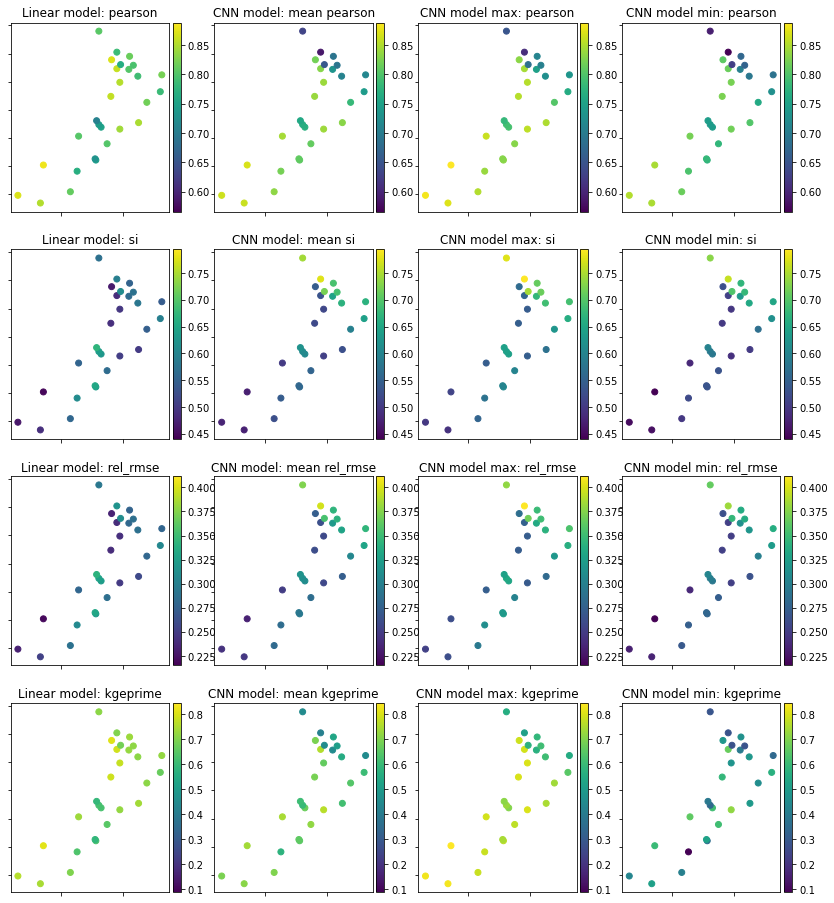

In [241]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

linear_results = xr.open_dataset('/home/metocean/geocean-nz-ss/data/statistics/experiments/experiment_linear_final_20211113.nc')
best_linear_results = linear_results.sel(grad=True, winds=True, tlapse=3, region='local_2.5_2.5', tresample='1D')
best_linear_results

sites = [s for s in best_linear_results.site.values if s in new_results]
metric = 'ext_kge_99'
metric = 'pearson'
metrics = ['pearson', 'si', 'rel_rmse', 'kgeprime']

lons = ss_dset.sel(site=sites).lon.values
lats = ss_dset.sel(site=sites).lat.values

fig, axes = plt.subplots(ncols=4, nrows=len(metrics), figsize=(14,4*len(metrics)))

for im, metric in enumerate(metrics):
    
    vals_linear = best_linear_results.sel(site=sites)[metric].values
    vals_nn = [np.mean([r[metric] for r in new_results[s].values()]) for s in sites]
    vals_nn_max = [np.max([r[metric] for r in new_results[s].values()]) for s in sites]
    vals_nn_min = [np.min([r[metric] for r in new_results[s].values()]) for s in sites]
    
    vmin = np.min([np.min(vals_linear), np.min(vals_nn), np.min(vals_nn_max), np.min(vals_nn_min)])
    vmax = np.max([np.max(vals_linear), np.max(vals_nn), np.max(vals_nn_max), np.max(vals_nn_min)])

    p=axes[im,0].scatter(lons, lats,
                      c=vals_linear, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,0].set_yticklabels([])
    axes[im,0].set_xticklabels([])
    axes[im,0].set_title("Linear model: "+metric)

    p=axes[im,1].scatter(lons, lats,
                      c=vals_nn, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,1].set_yticklabels([])
    axes[im,1].set_xticklabels([])
    axes[im,1].set_title("CNN model: mean "+metric)

    p=axes[im,2].scatter(lons, lats,
                      c=vals_nn_max, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,2].set_yticklabels([])
    axes[im,2].set_xticklabels([])
    axes[im,2].set_title("CNN model max: "+metric)

    p=axes[im,3].scatter(lons, lats,
                      c=vals_nn_min, vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(axes[im,3])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(p, cax=cax, orientation='vertical')
    axes[im,3].set_yticklabels([])
    axes[im,3].set_xticklabels([])
    axes[im,3].set_title("CNN model min: "+metric)

#for v1,v2,v3 in zip(vals_nn, vals_nn_max, vals_nn_min):
#    print(v1,v2,v3)


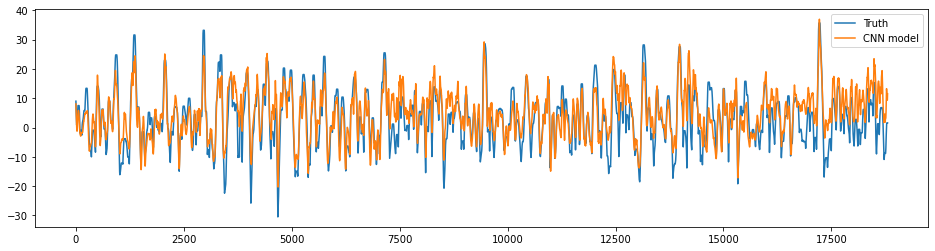

In [187]:
#fig, axes = plt.subplots(figure=(16,4))
#axes.plot(np.concatenate([y.numpy()[:,0] for x, y in dset_val], axis=0))
#axes.plot(prediction_val[:,0])

from matplotlib import pyplot as plt
fig,axes = plt.subplots(figsize=(16,4))
plt.plot(np.concatenate([y.numpy()[:,0] for x, y in dset_val], axis=0)[20000:40000], label='Truth')
plt.plot(prediction_val[20000:40000,0], label='CNN model')
plt.legend()